In [1]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from nltk.stem import *
from nltk.corpus import stopwords
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from nltk.tokenize import WhitespaceTokenizer
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
import time
import sklearn
import warnings
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, cohen_kappa_score,make_scorer
import pickle

In [4]:
df = pd.read_excel('iphproductdata2_10.xlsx')
df.head()

Country Code         IPH Category IPH Sub Category  \
0           AT  General Merchandise        Batteries   
1           AT  General Merchandise        Batteries   
2           AT  General Merchandise        Batteries   
3           AT  General Merchandise        Batteries   
4           AT  General Merchandise        Batteries   

                                        Product  \
0  LL Altartikel Varta longlife Mono D 1,5V 1St   
1          Varta Electronics CR2016 Blister 2St   
2                   Varta Knopfzelle CR2025 2St   
3                Varta longlife Mono D 1,5V 1St   
4          Varta Longlife Power 9V Blister 10St   

                     Product Description Product Code  Gross Sales USD  
0     OL: Varta longlife Mono D 1.5V 1st       100832        1708.0190  
1   Varta Electronics CR2016 Blister 2pc       116270         391.2206  
2          OL: Varta Erlectronics CR2025       110202        2789.4703  
3     OL: Varta longlife Mono D 1.5V 1st       100832        1819.7663  
4  Varta Longlife Power 9V Blister 10pcs       100836         111.1617

In [5]:
df.isna().sum()

Country Code              0
IPH Category              0
IPH Sub Category          0
Product                   0
Product Description       0
Product Code              0
Gross Sales USD        1386
dtype: int64

In [6]:
df = df.drop(index=df[df.duplicated(['Product Description'])].index) 

In [7]:
df['Final_Category'] = df['IPH Category'].str.cat(df[['IPH Sub Category']].values,sep=' - ')

In [8]:
df['Final_Category'].head()

0    General Merchandise - Batteries
1    General Merchandise - Batteries
2    General Merchandise - Batteries
4    General Merchandise - Batteries
6    General Merchandise - Batteries
Name: Final_Category, dtype: object

In [9]:
df['Final_Category'].nunique()

45

In [10]:
final_categories_counts = df['Final_Category'].value_counts().sort_values(ascending=True)

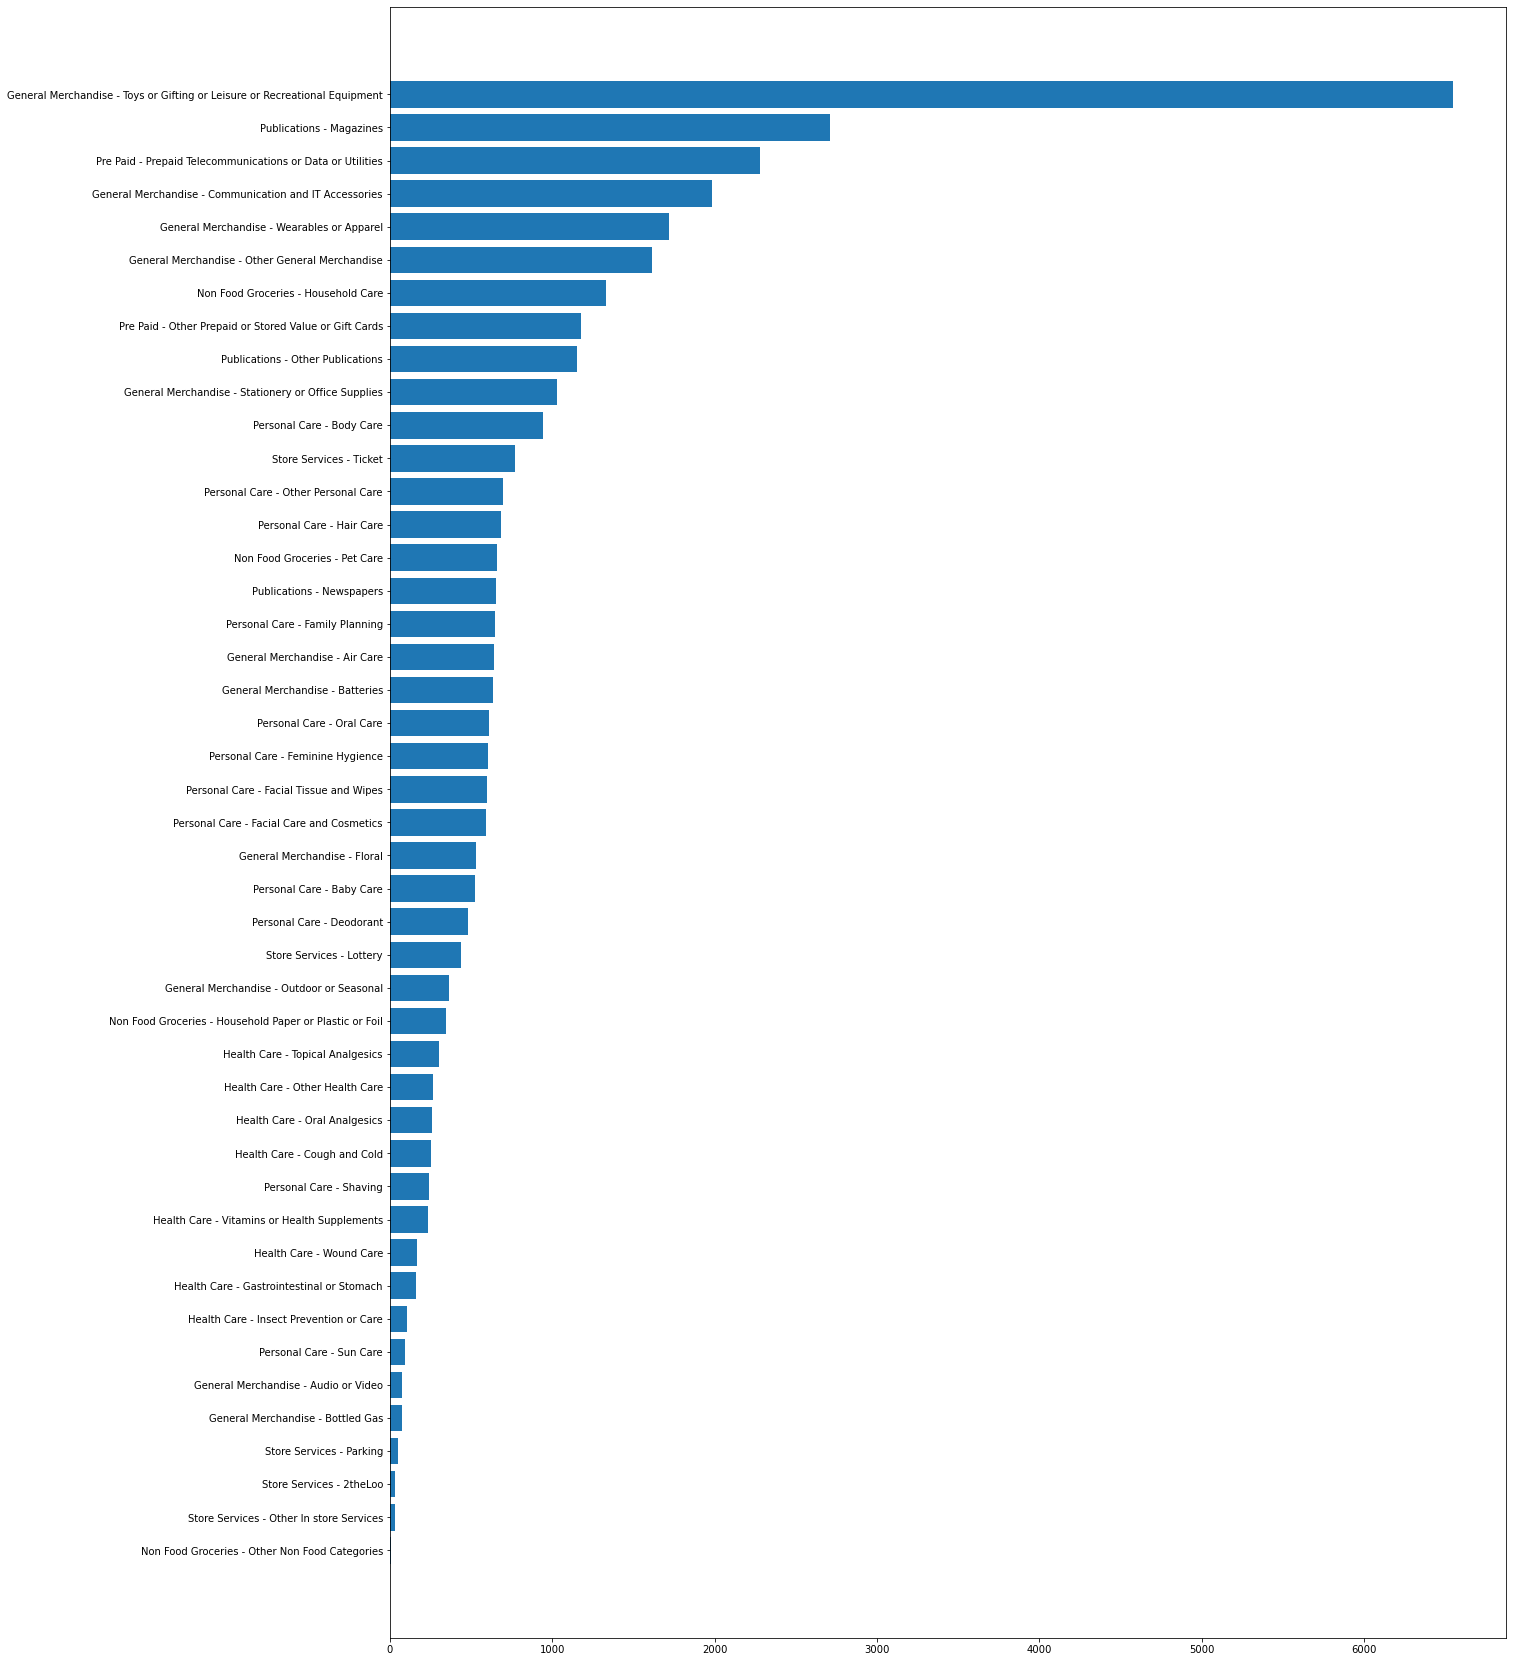

In [11]:
plt.figure(figsize=(20,30))
plt.barh(final_categories_counts.index, final_categories_counts)
plt.xlabel=None

In [12]:
final_categories_counts.head(30)

Non Food Groceries - Other Non Food Categories               5
Store Services - Other In store Services                    29
Store Services - 2theLoo                                    33
Store Services - Parking                                    48
General Merchandise - Bottled Gas                           75
General Merchandise - Audio or Video                        77
Personal Care - Sun Care                                    92
Health Care - Insect Prevention or Care                    102
Health Care - Gastrointestinal or Stomach                  161
Health Care - Wound Care                                   165
Health Care - Vitamins or Health Supplements               237
Personal Care - Shaving                                    242
Health Care - Cough and Cold                               252
Health Care - Oral Analgesics                              259
Health Care - Other Health Care                            263
Health Care - Topical Analgesics                       

In [13]:
small_count_categories = final_categories_counts[final_categories_counts<=5].index

In [14]:
len(small_count_categories)

1

In [15]:
df['Final_Category'].replace(to_replace=small_count_categories, value='Other', inplace=True)

In [16]:
df['codes'] = df['Final_Category'].astype('category').cat.codes
df['codes'].nunique()

45

In [17]:
code_dictionary = dict(set(list(zip(df['codes'], df['Final_Category']))))

In [18]:
X = df['Product Description']
y = df['codes']

In [19]:
tokenizer = WhitespaceTokenizer()

In [20]:
#from wordcloud import WordCloud
#word_cloud = WordCloud(width = 1000,
                       #height = 800,
                       #colormap = 'Blues', 
                       #margin = 0,
                       #max_words = 183,  
                       #max_font_size = 120, min_font_size = 15,  
                       #background_color = "white").generate(" ".join(X_train))

#plt.figure(figsize = (10, 15))
#plt.imshow(word_cloud, interpolation = "gaussian")
#plt.axis("off")
#plt.show()

In [21]:
def plot_most_common_features(text_col, target_col, n_features=50):
    from matplotlib import interactive

    df = pd.DataFrame({"text": text_col, "CLASS": target_col})
    grouped = df.groupby(["CLASS"]).apply(lambda x: x["text"].sum())
    grouped_df = pd.DataFrame({"CLASS": grouped.index, "text": grouped.values})

    from nltk.tokenize import WhitespaceTokenizer
    tokenizer = WhitespaceTokenizer()

    for ii, text in enumerate(grouped_df.text):
        pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))
        plt.title(grouped_df.CLASS[ii], fontsize=20)
        plt.xticks(fontsize=15)
        plt.legend([])
        interactive(True)
        plt.show()

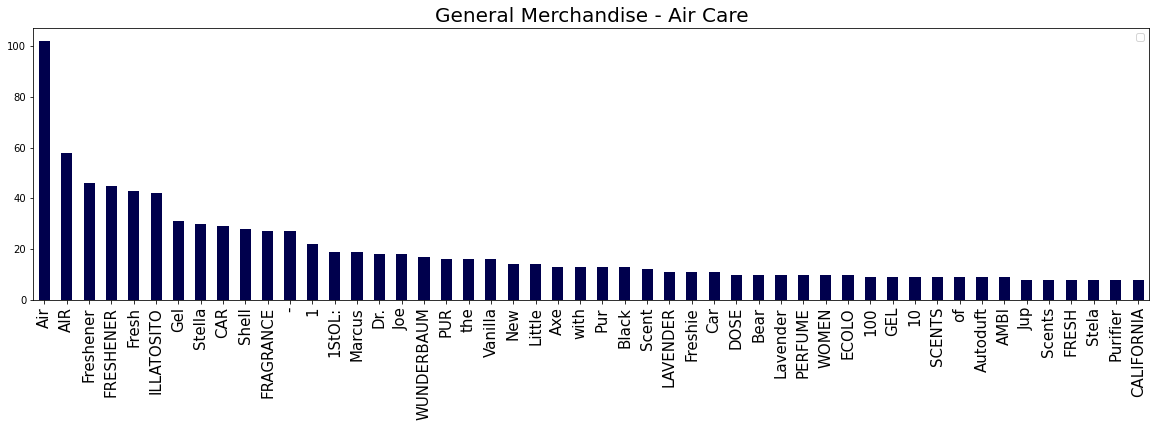

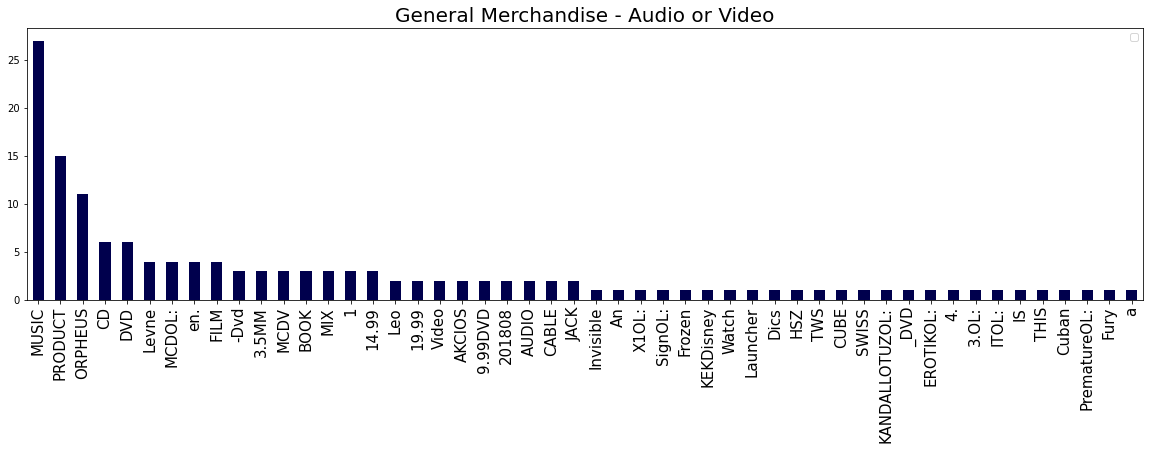

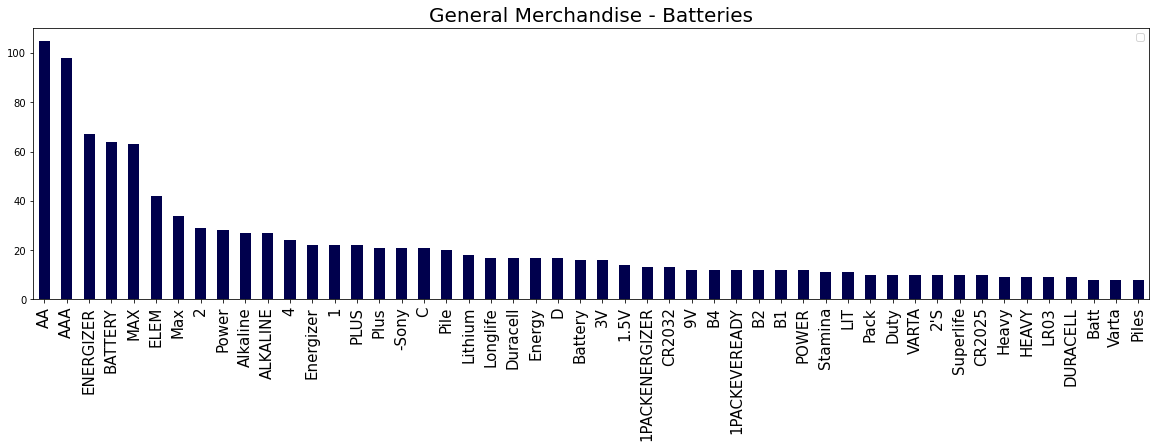

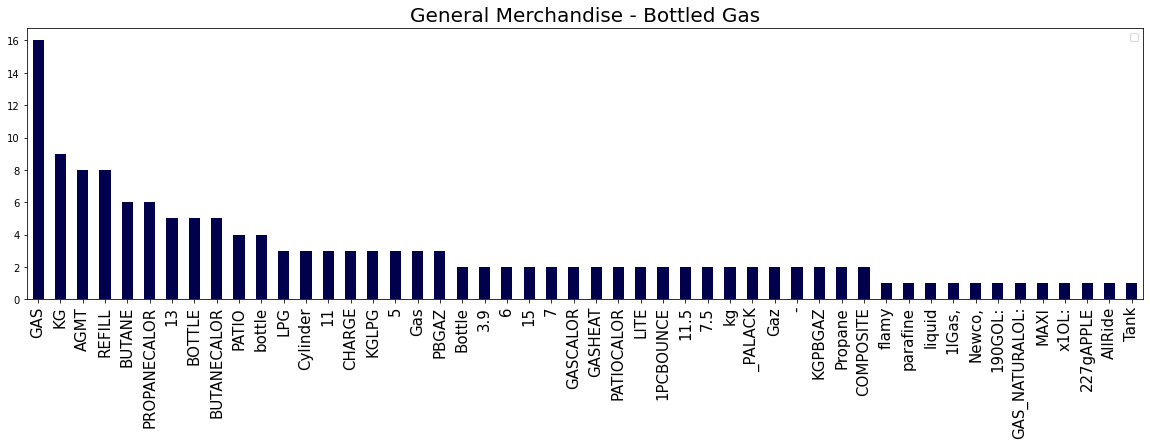

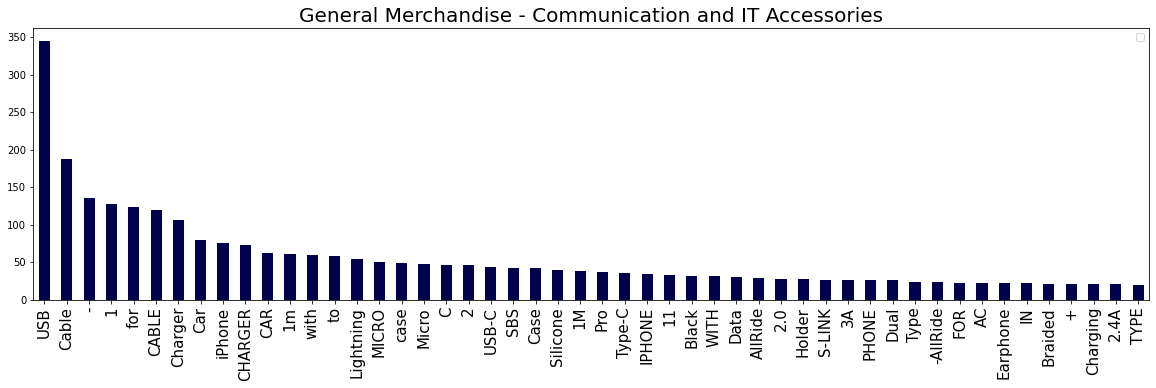

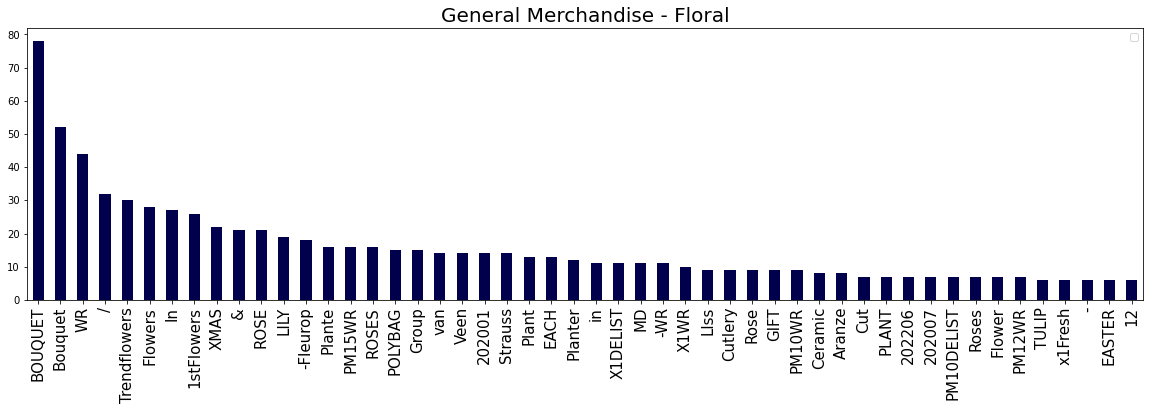

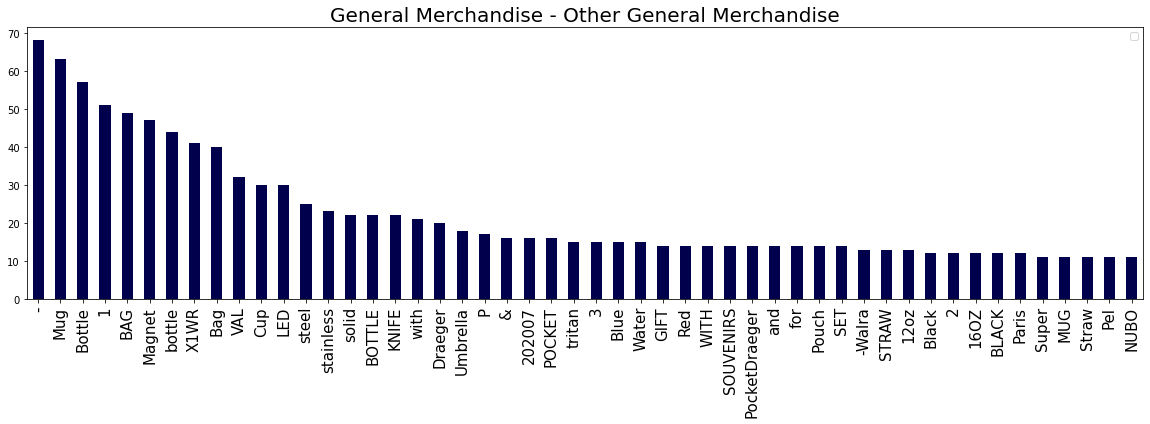

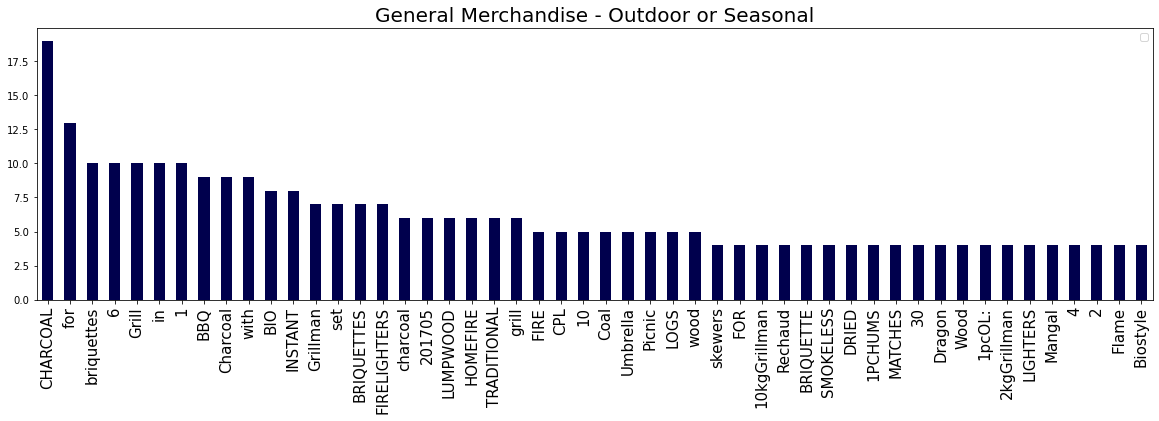

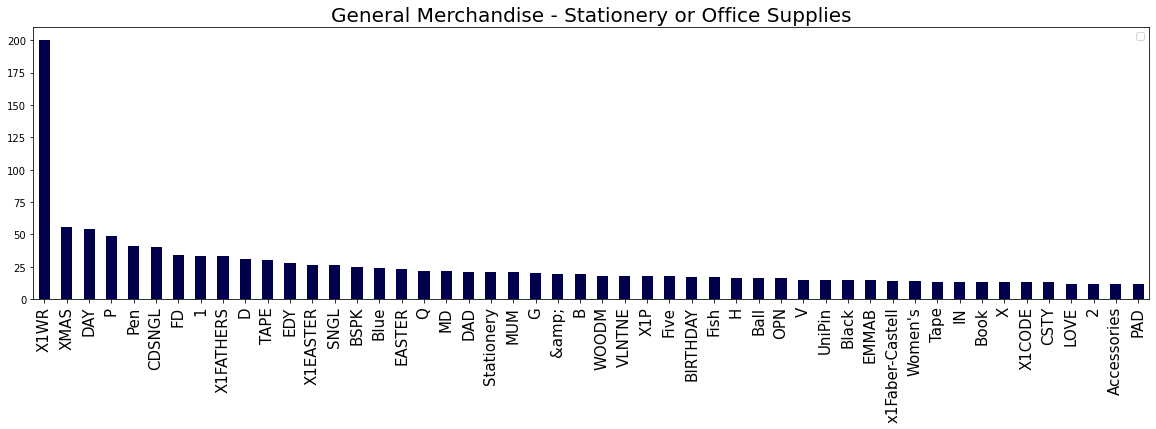

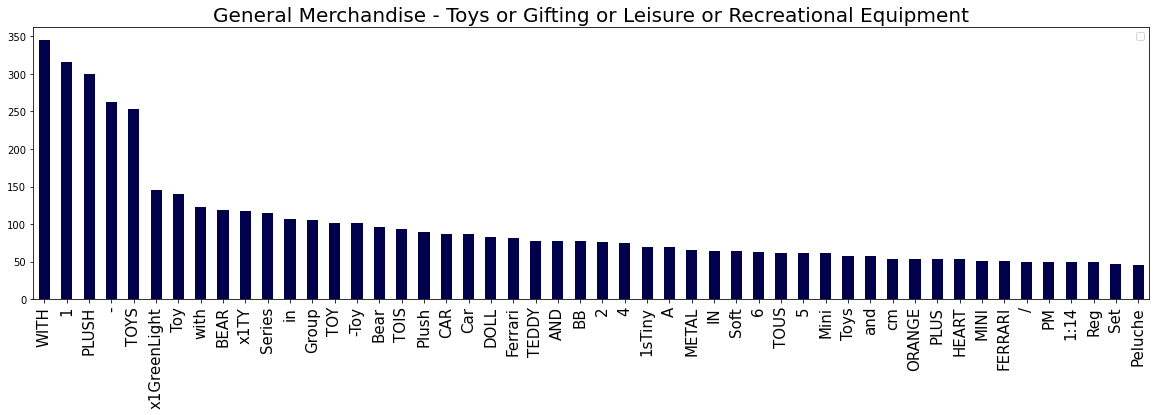

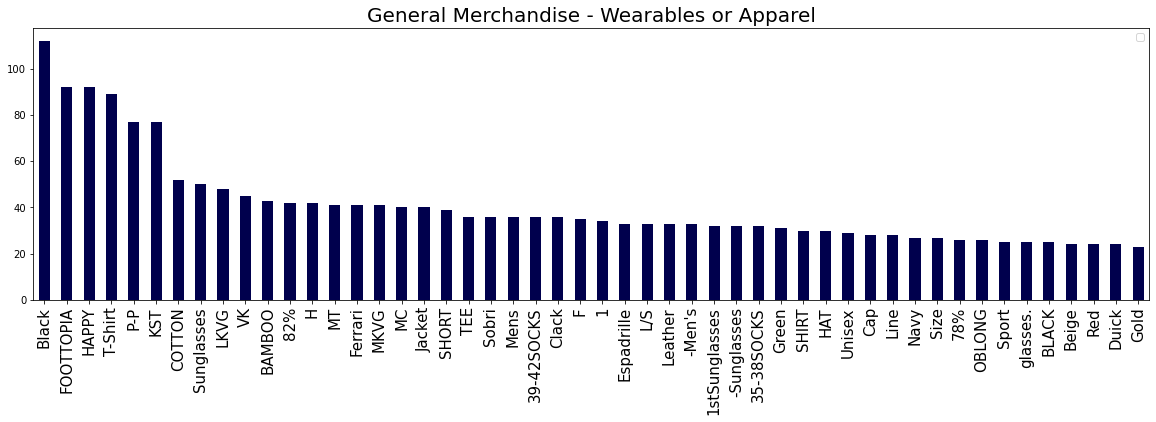

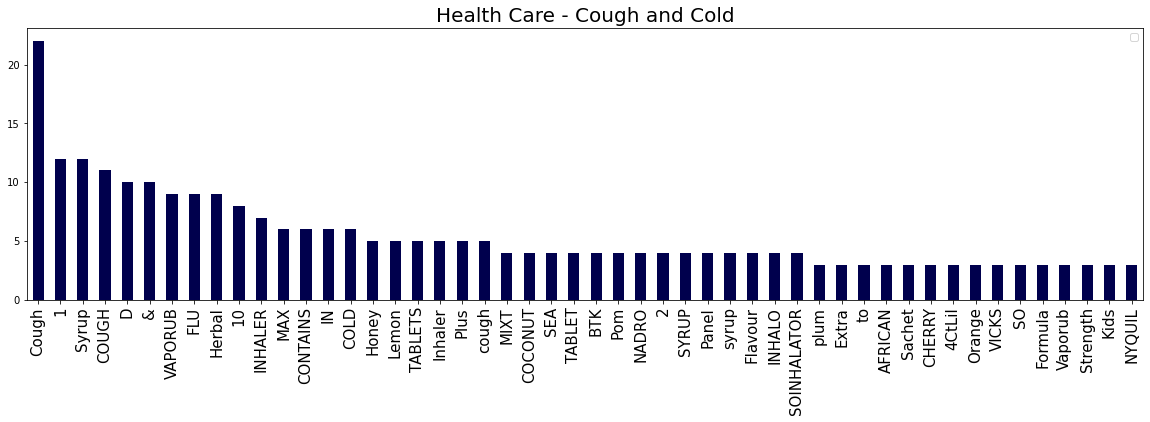

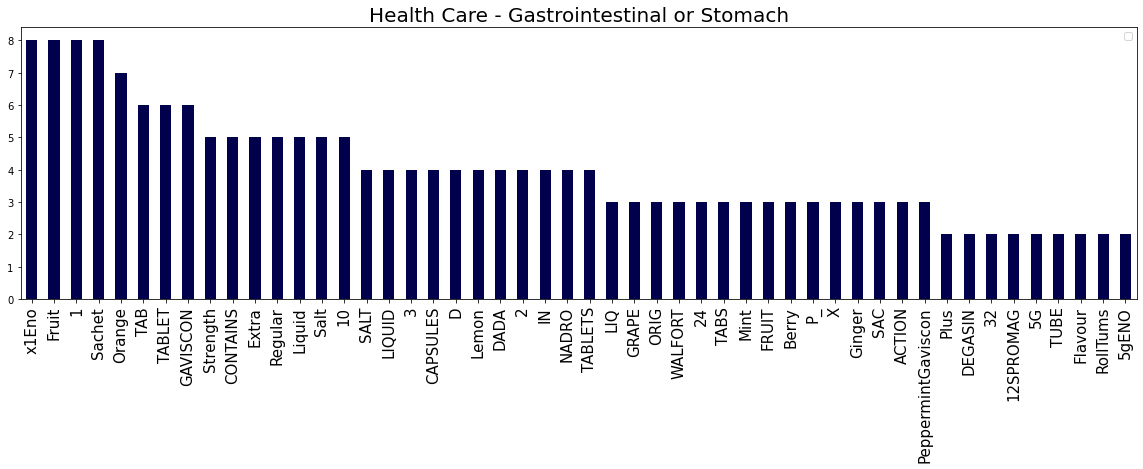

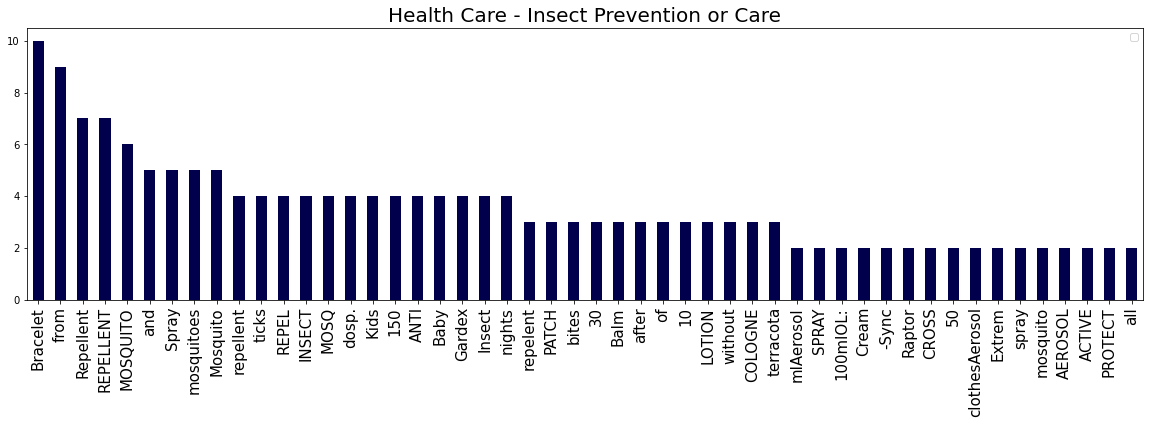

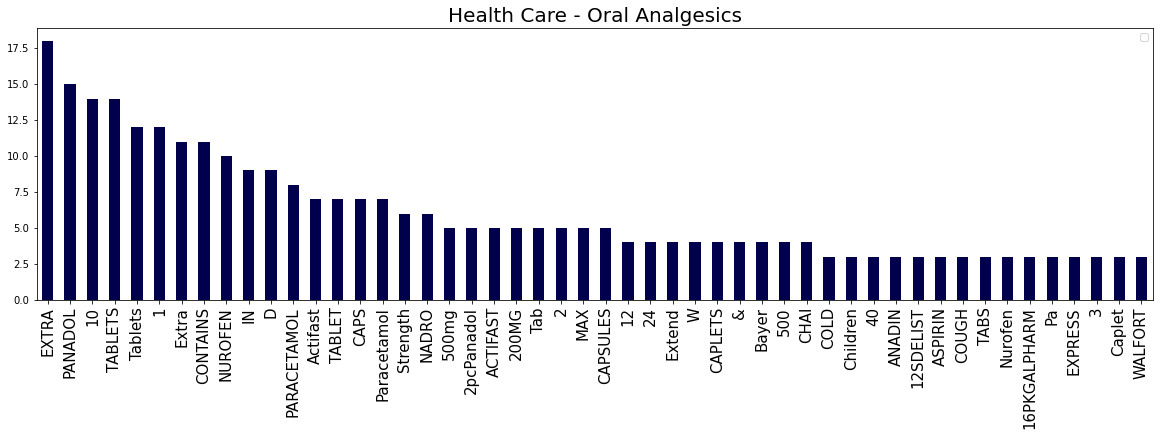

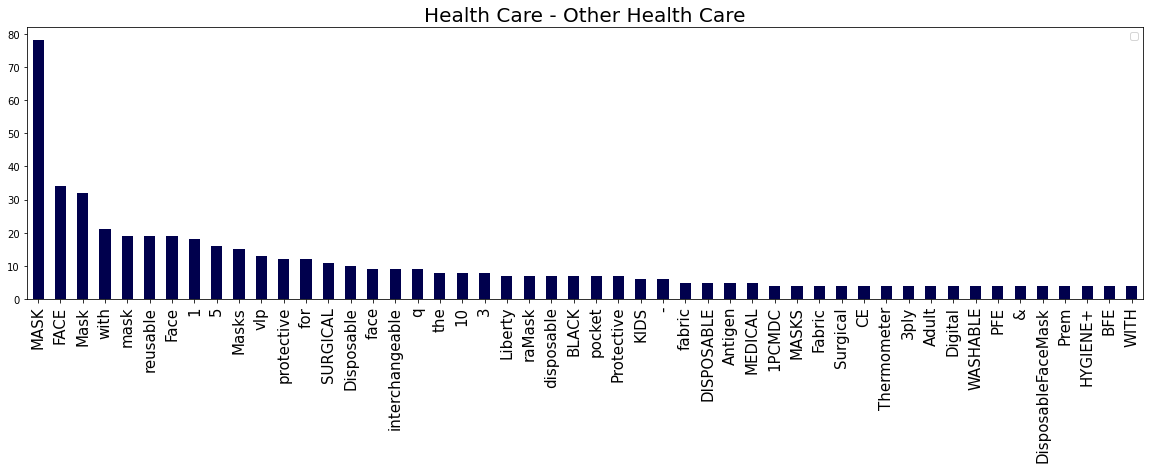

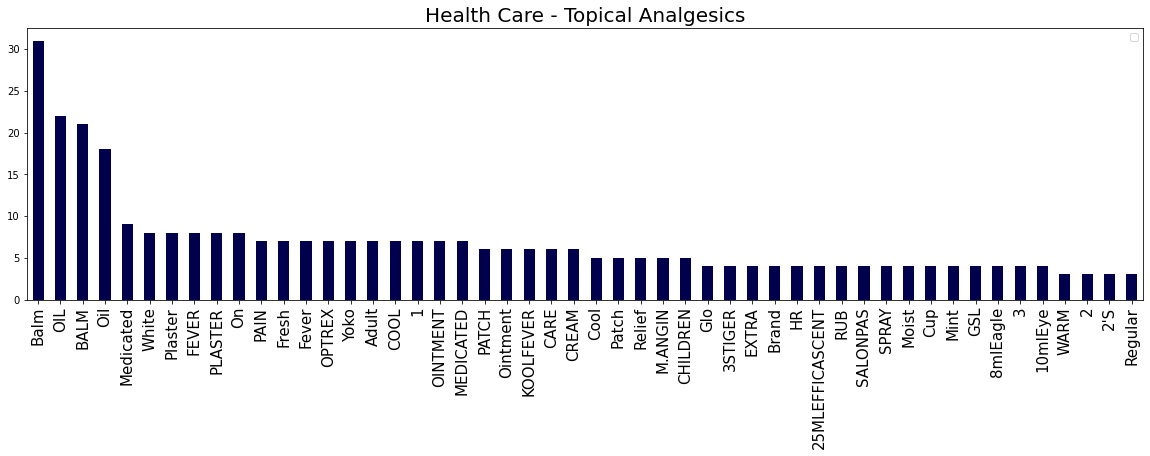

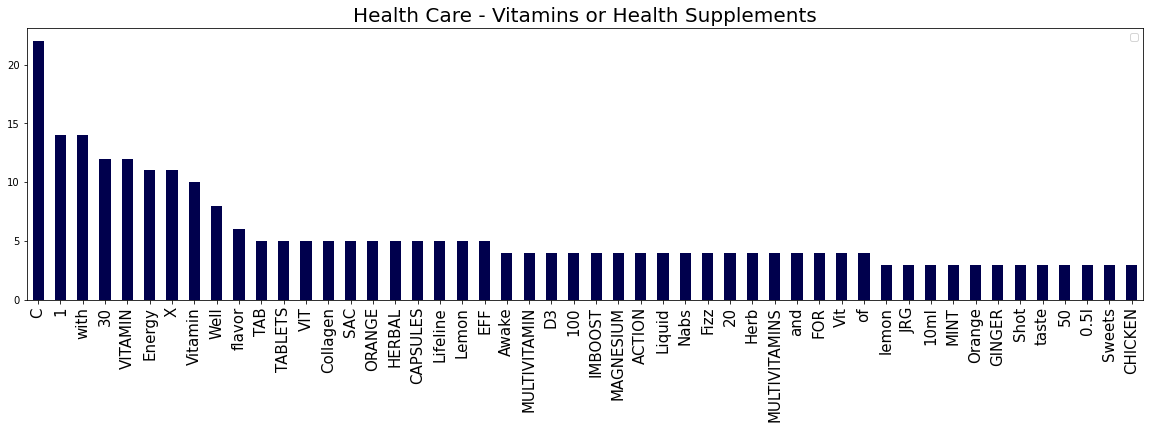

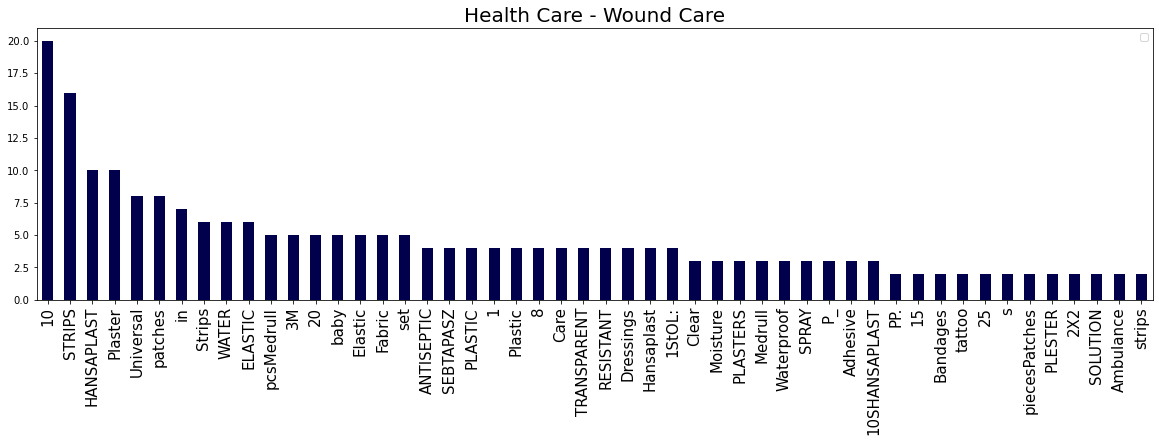

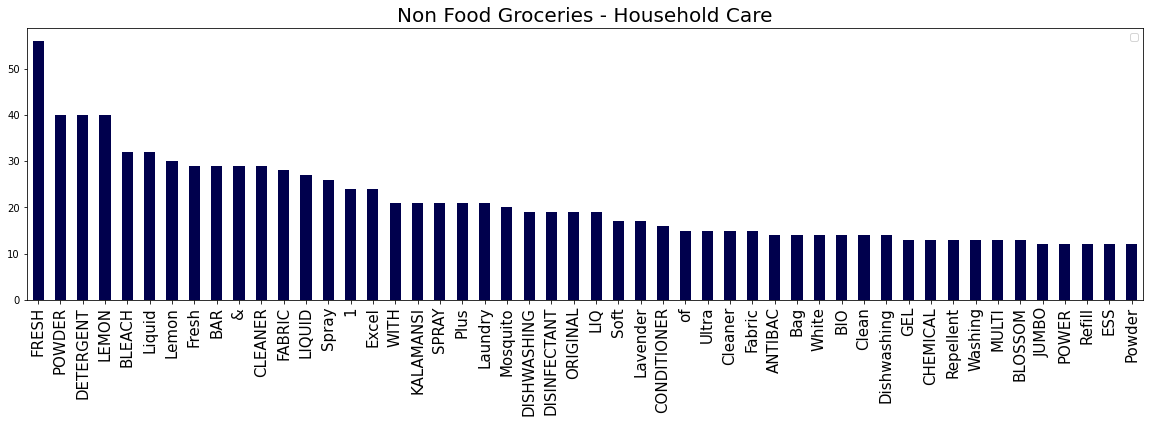

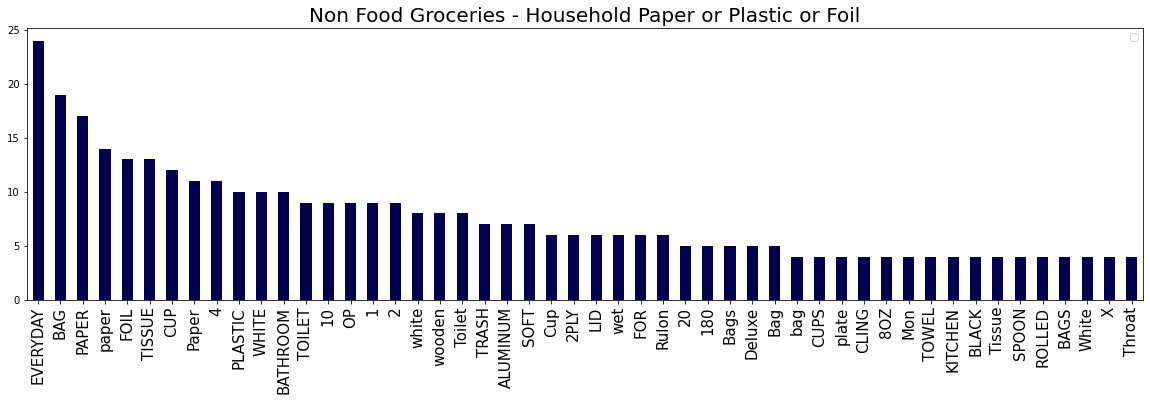

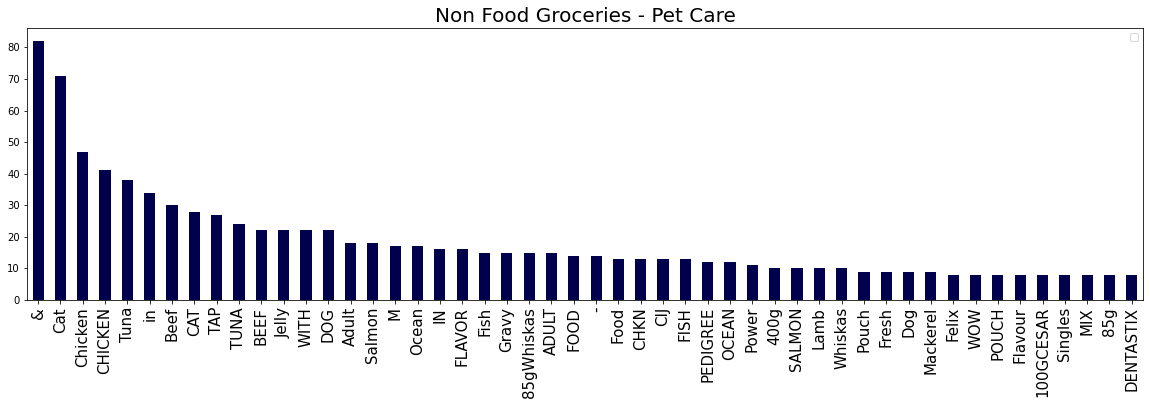

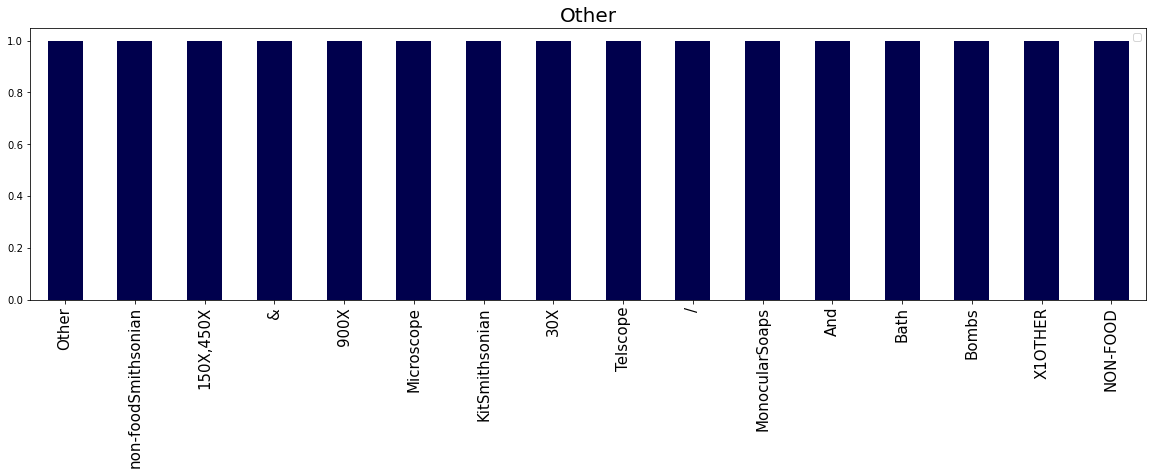

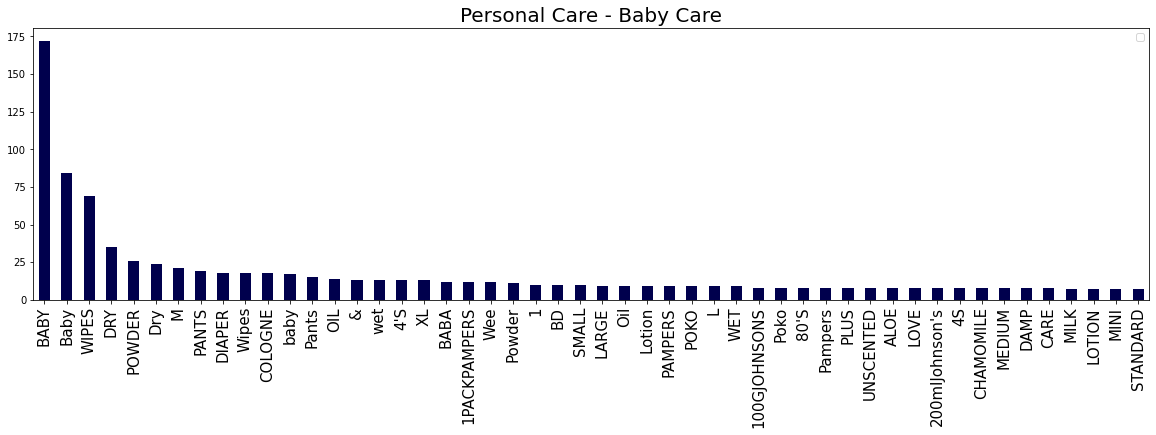

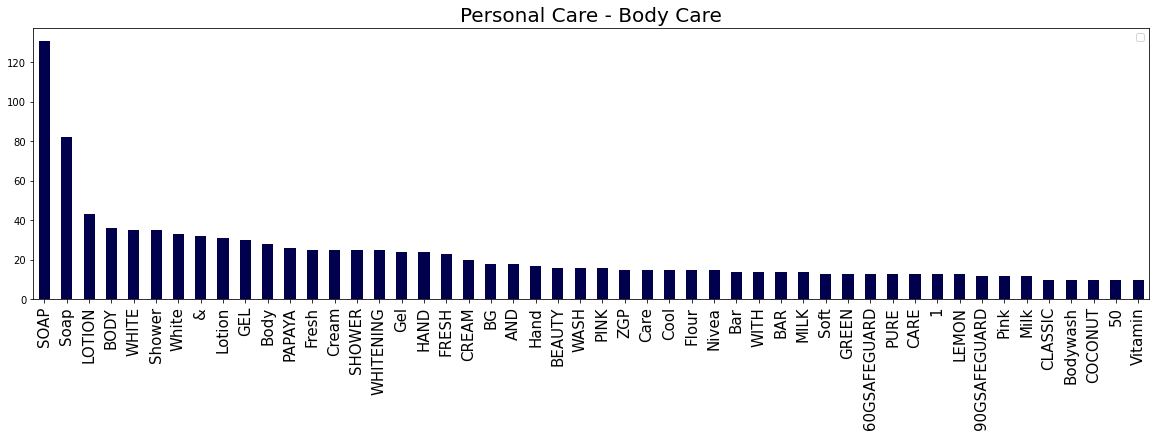

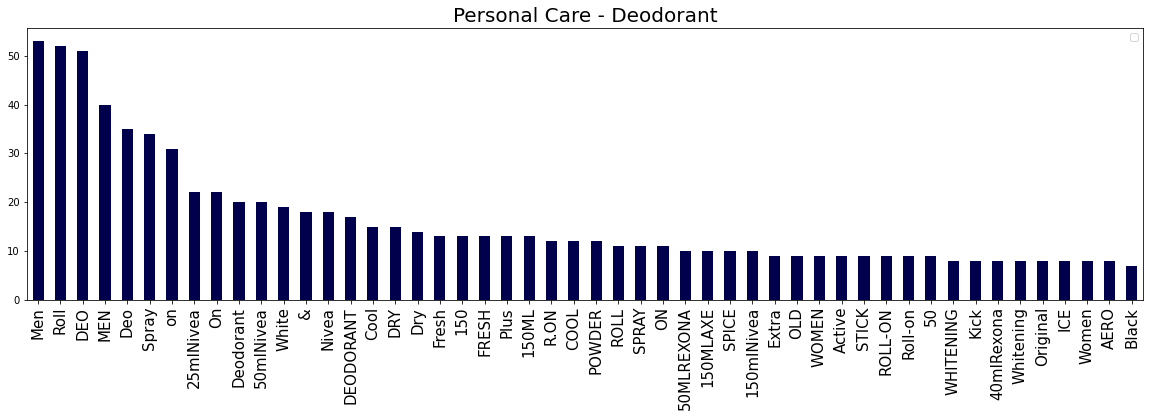

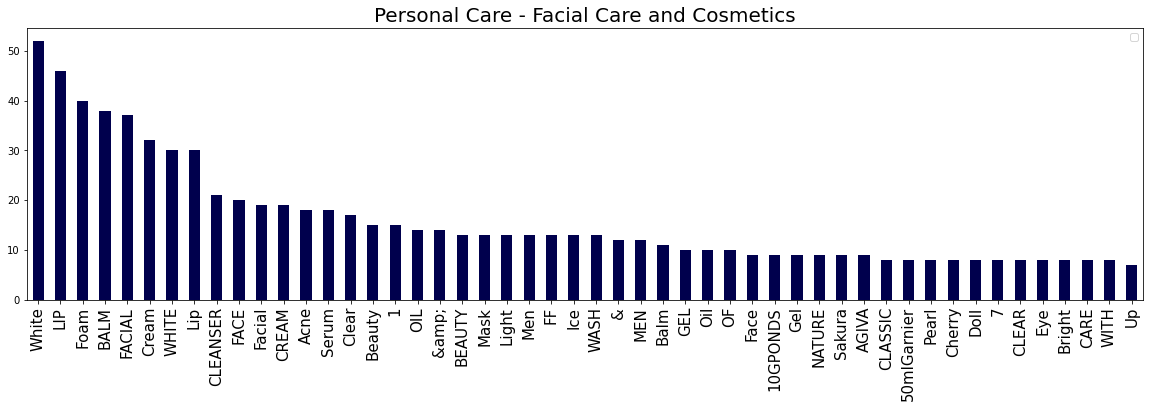

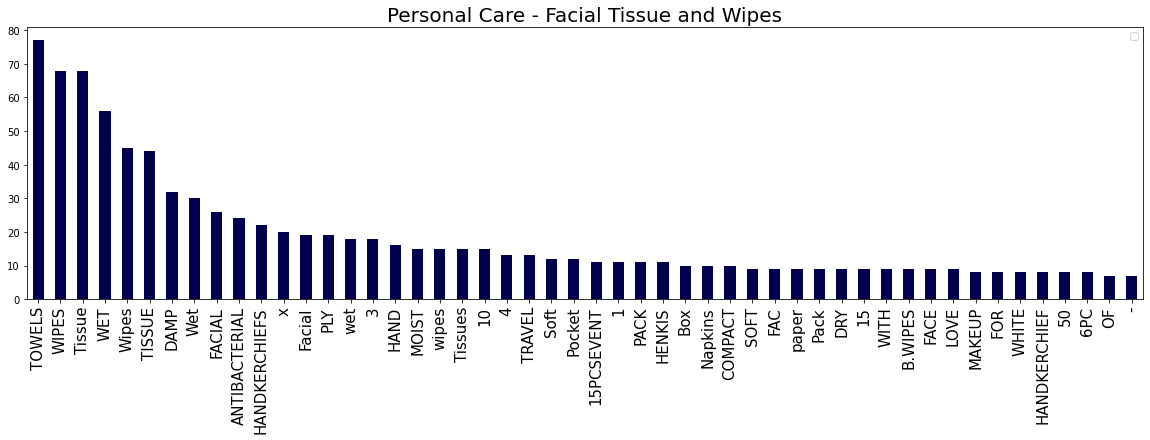

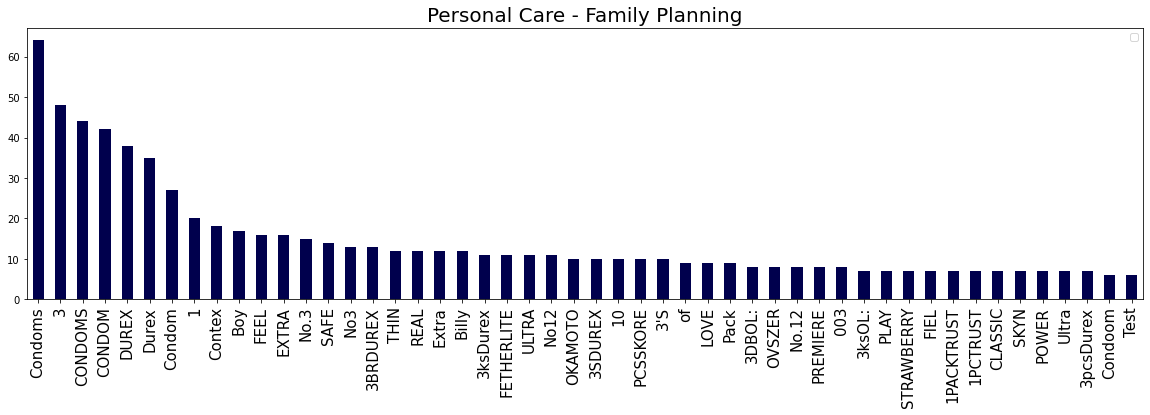

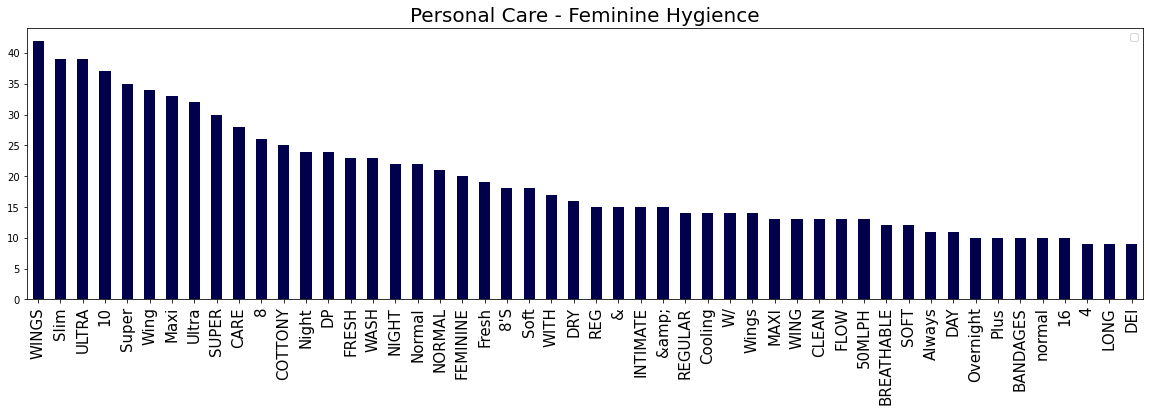

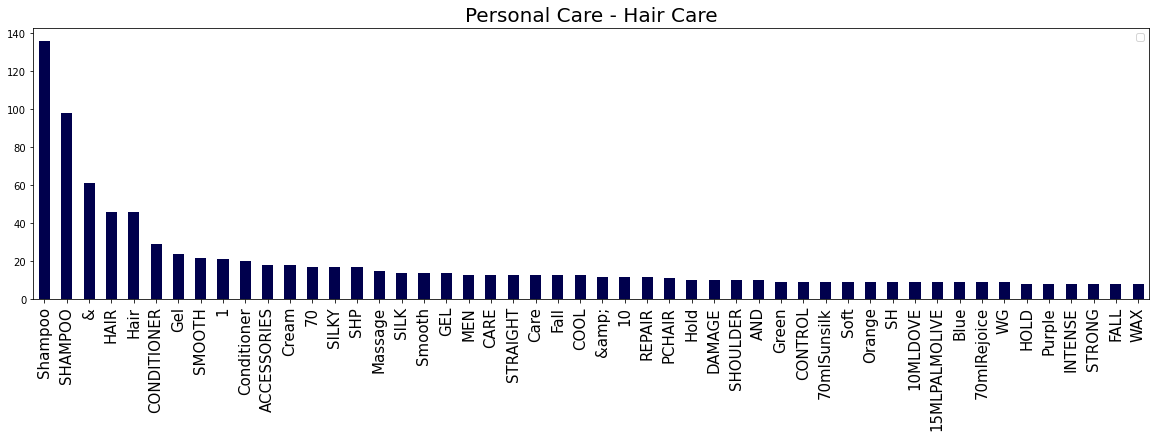

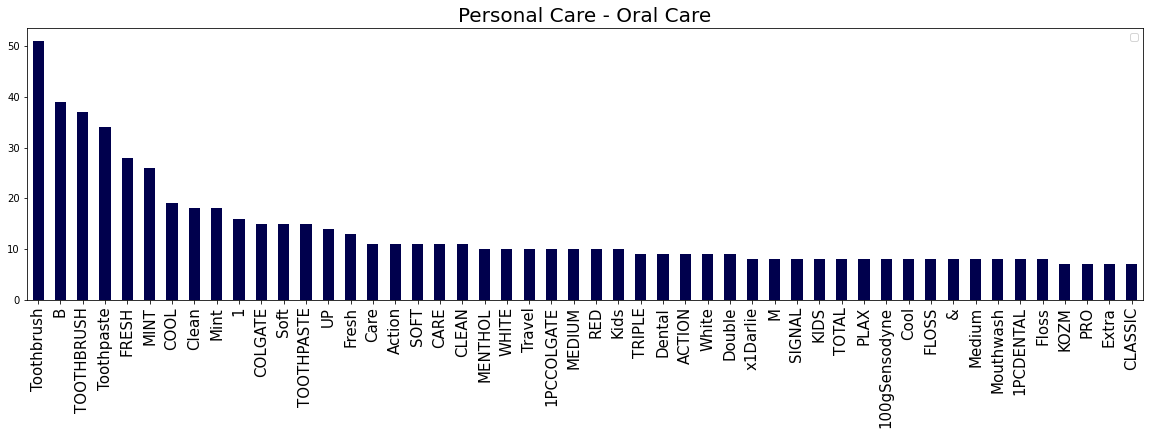

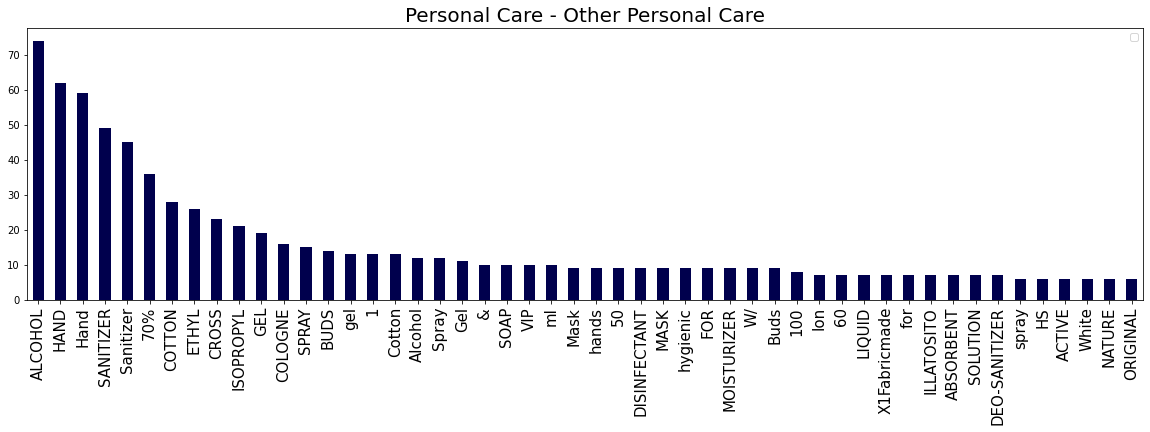

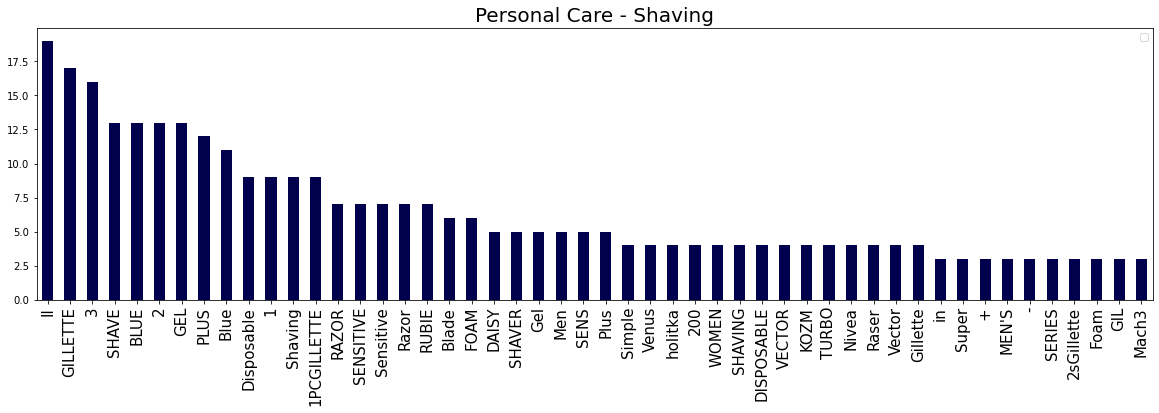

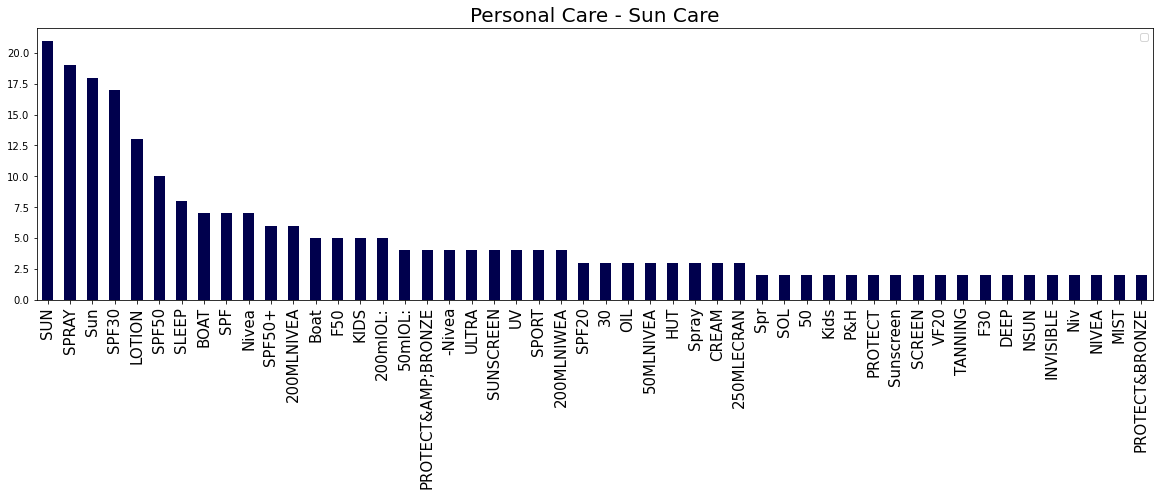

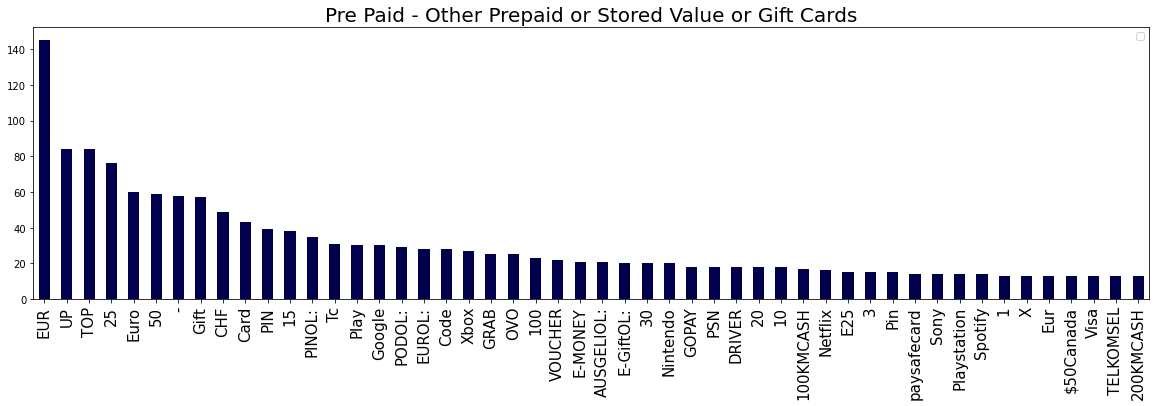

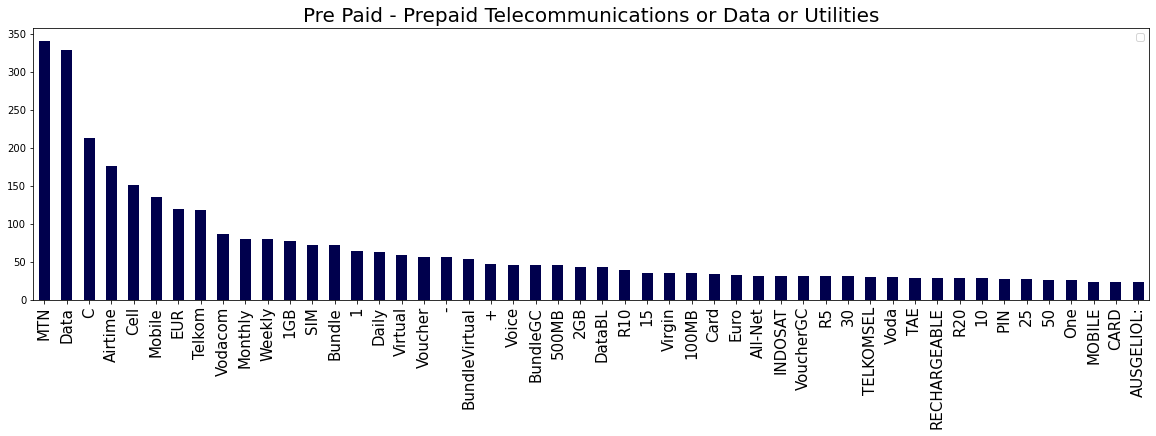

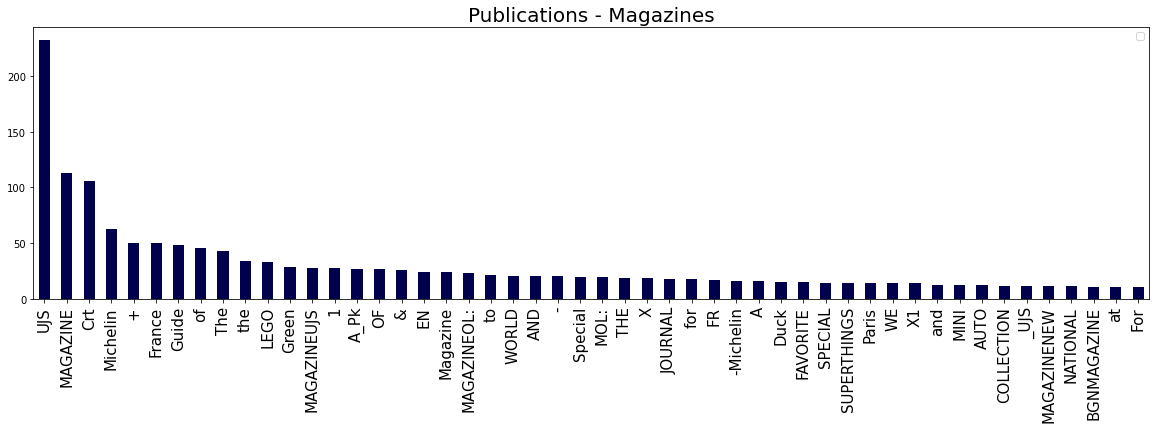

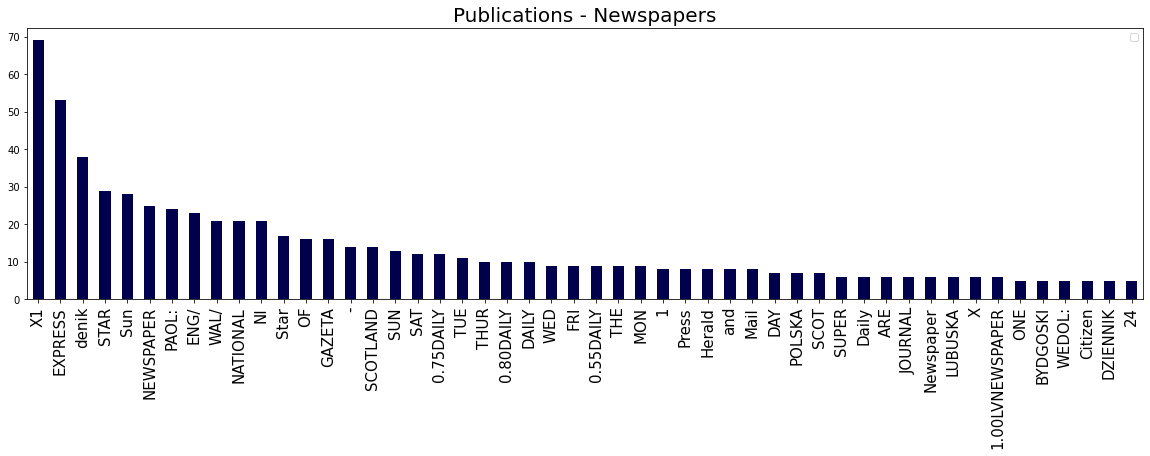

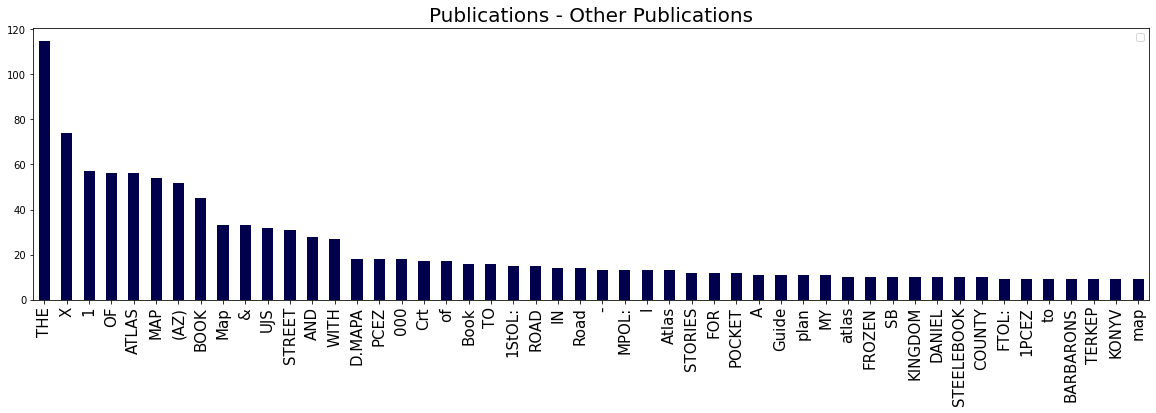

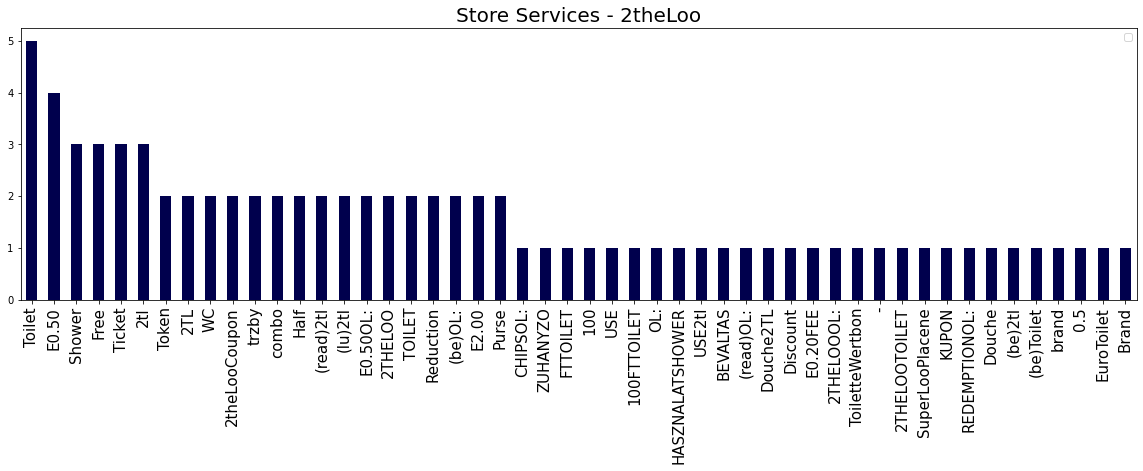

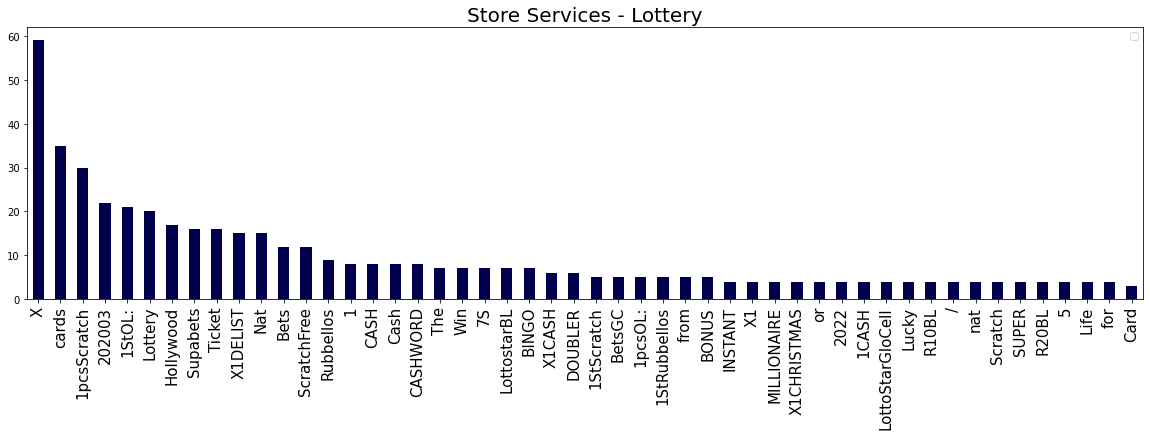

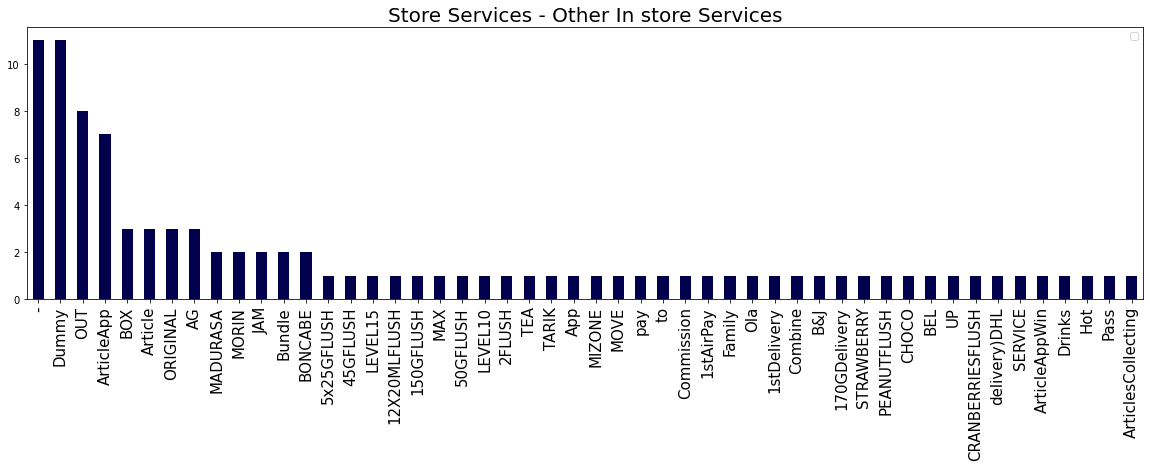

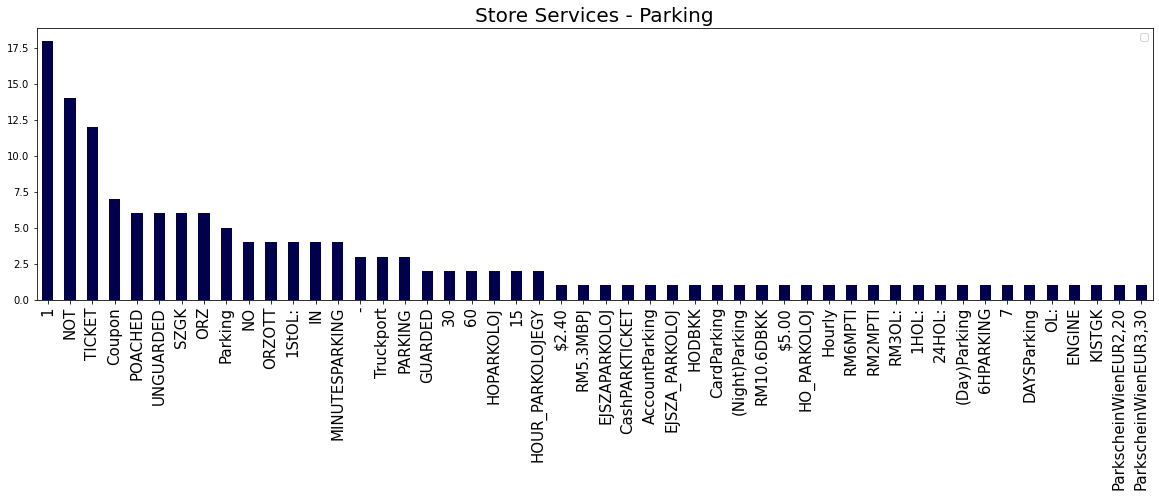

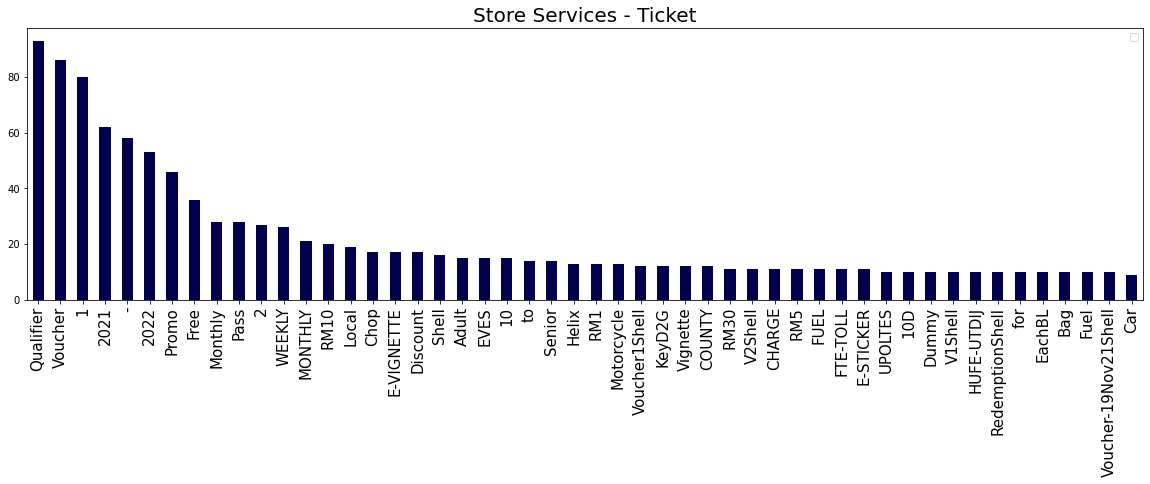

In [22]:
plot_most_common_features(X,df['Final_Category'])

In [23]:
nltk.download('stopwords')

from nltk.stem import SnowballStemmer


def stemming(raw_text):
    
    stemmer = SnowballStemmer('english')
    stemmed = [stemmer.stem(word) for word in raw_text]
    
    return("".join(stemmed))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\S.Subramanian2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
nltk.download('stopwords')

from nltk.stem import SnowballStemmer


def process_text(raw_text):

    letters_only = re.sub("[^a-zA-Z]", " ",raw_text)
    no_one_letter = re.sub(r"\b[a-zA-Z]\b","",letters_only)
    words = no_one_letter.lower().split()
    
    stops = set(stopwords.words("english")) 
    not_stop_words = [w for w in words if not w in stops]

    final_words = [word for word in not_stop_words]
    
    return( " ".join( final_words ))  

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\S.Subramanian2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
X_cleaner = X.apply(lambda x: process_text(x))

In [26]:
X_cleaner_2 = X_cleaner.apply(lambda x: stemming(x))

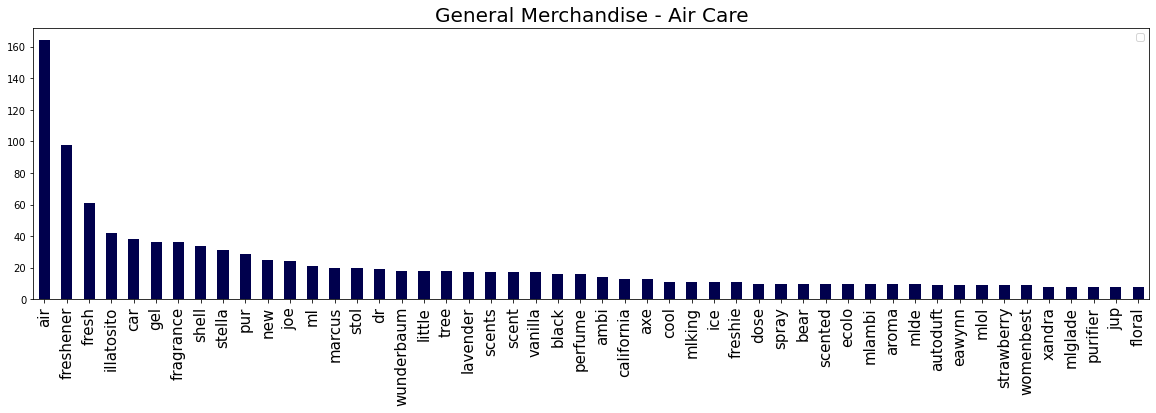

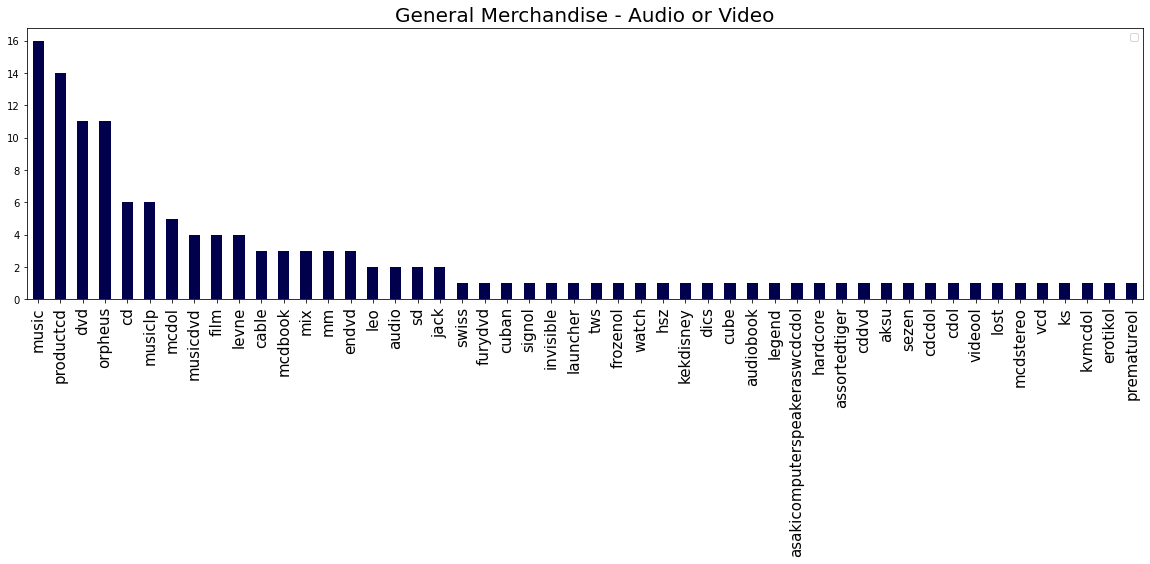

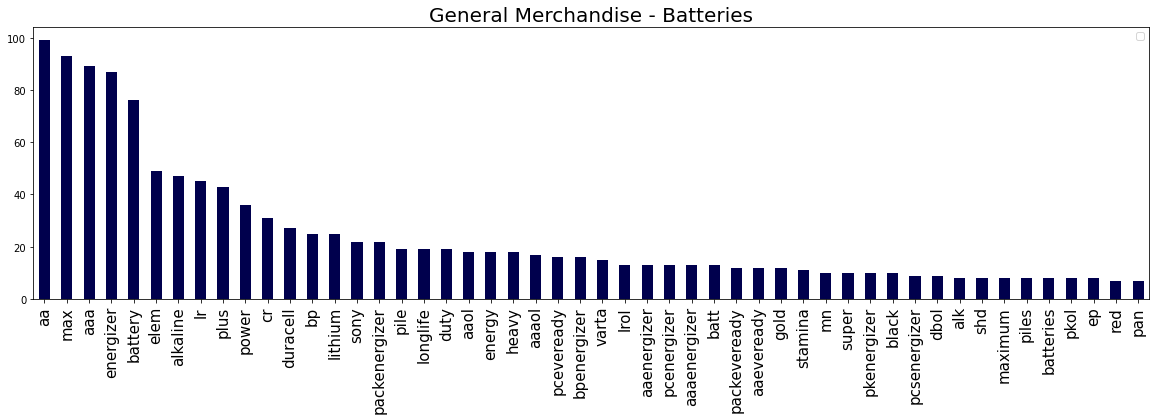

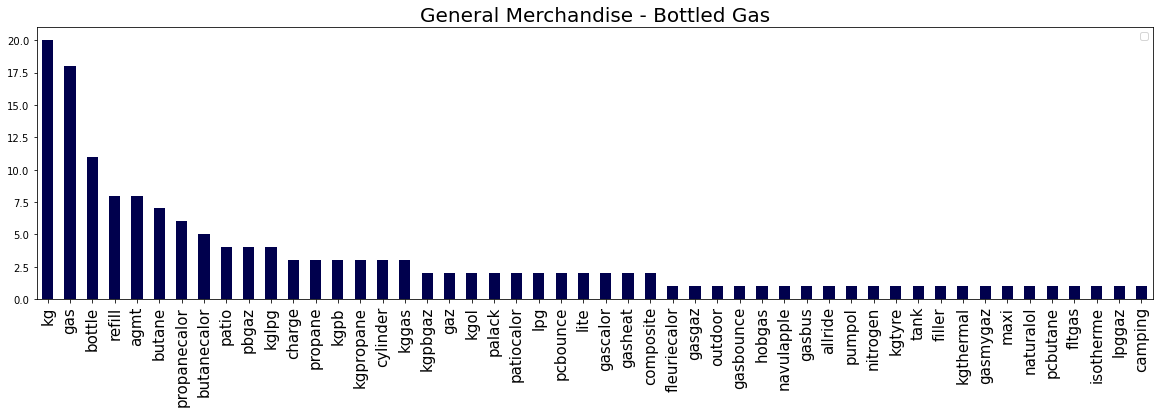

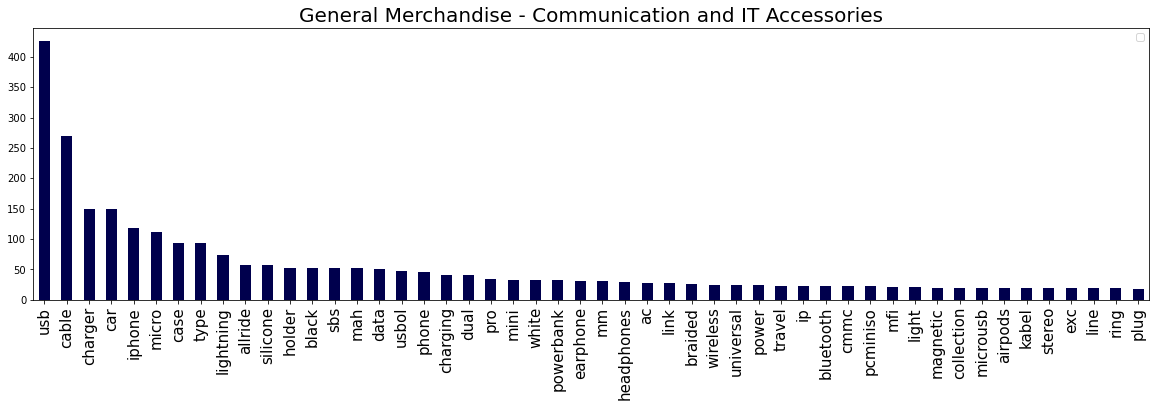

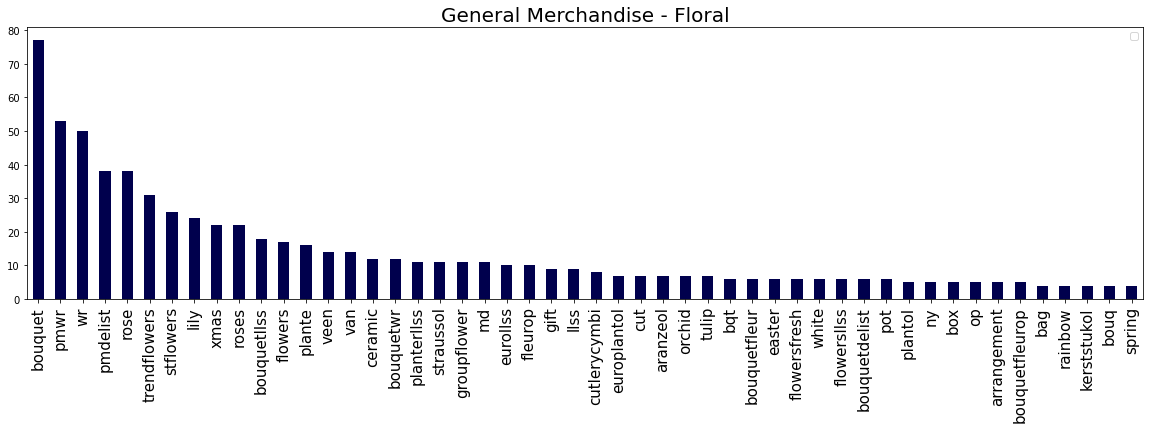

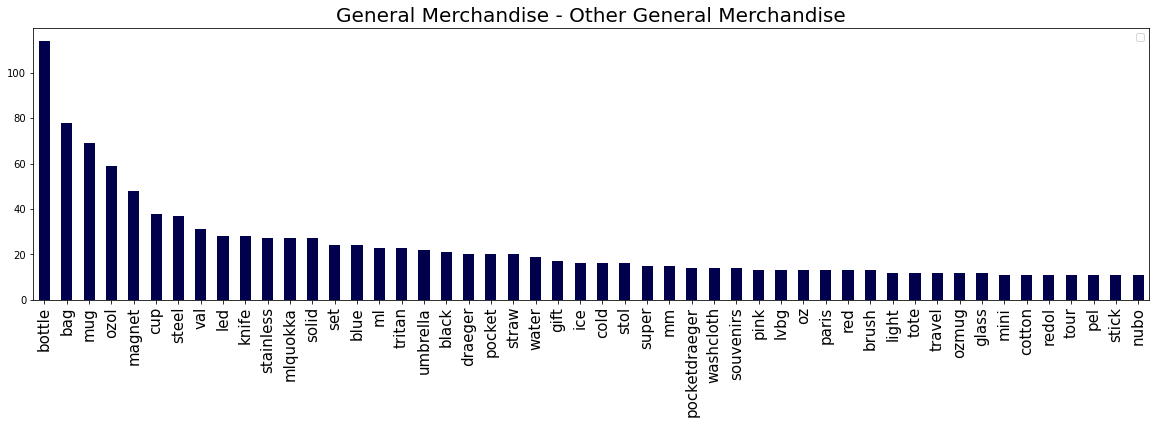

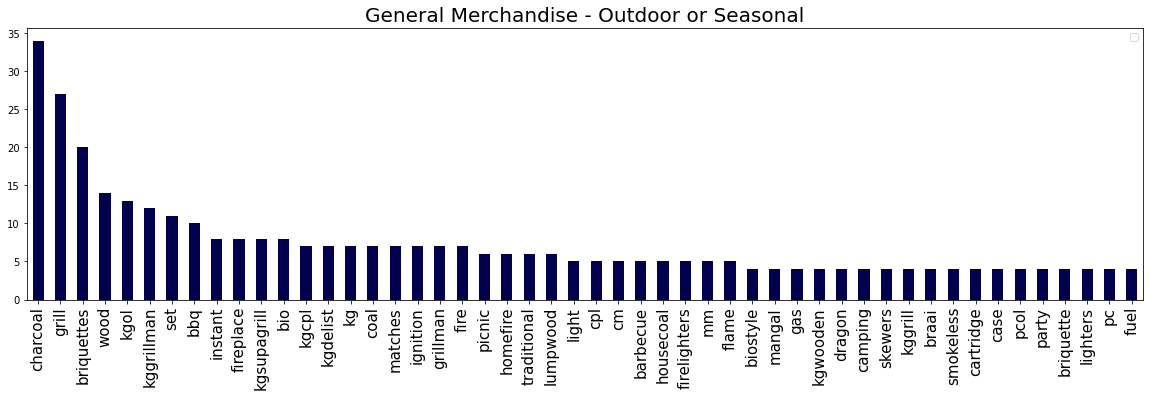

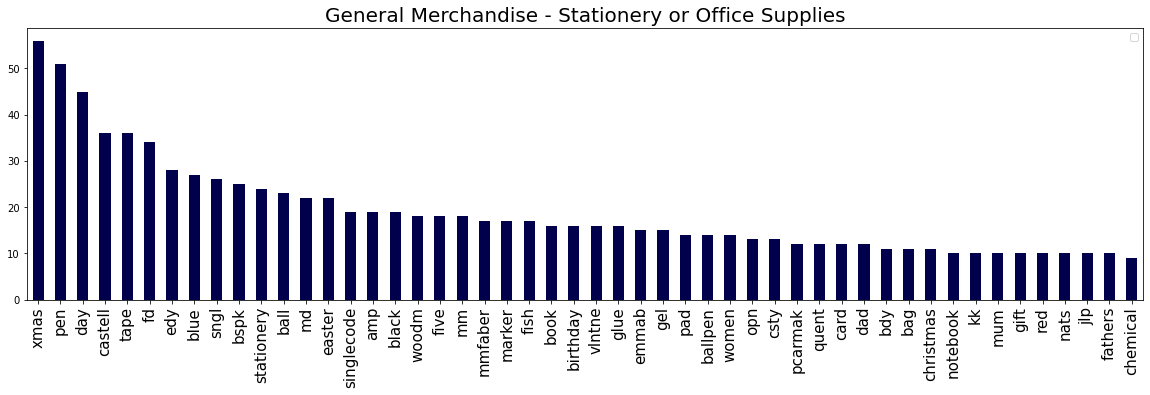

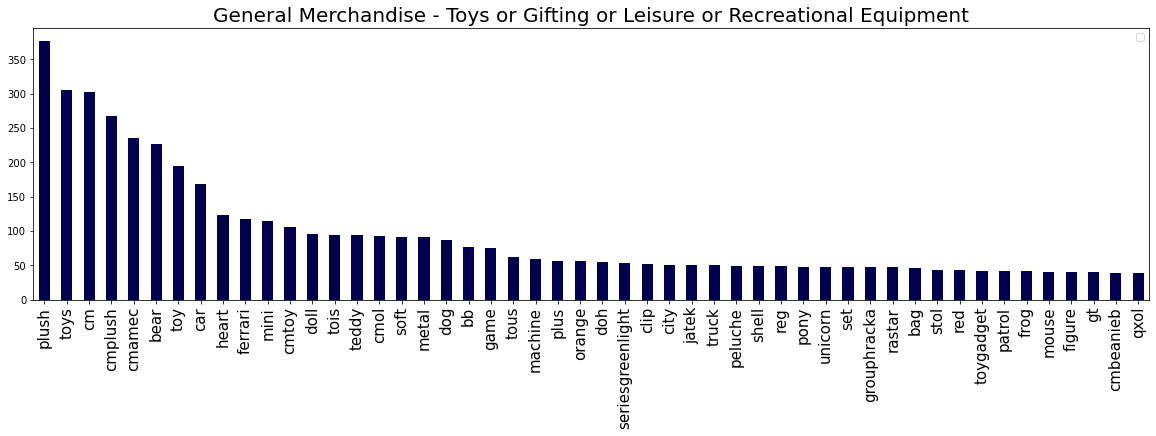

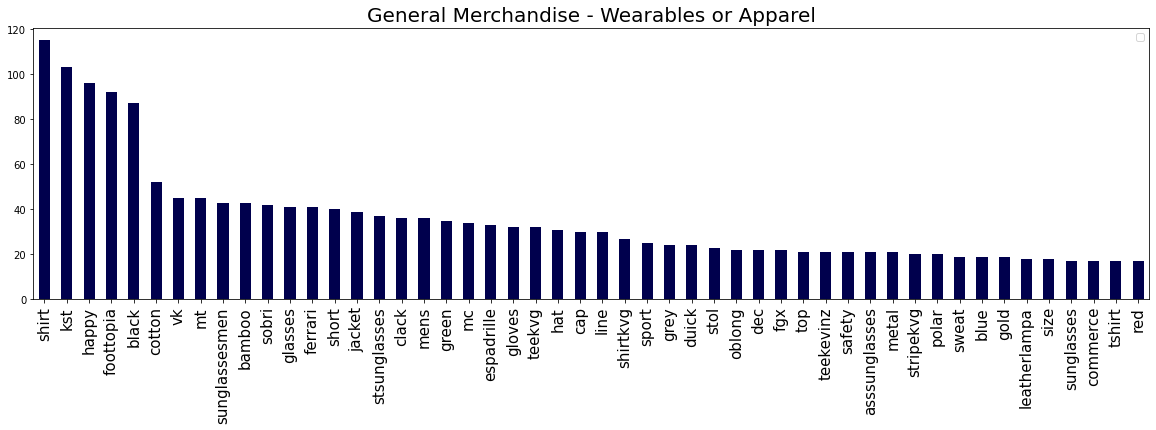

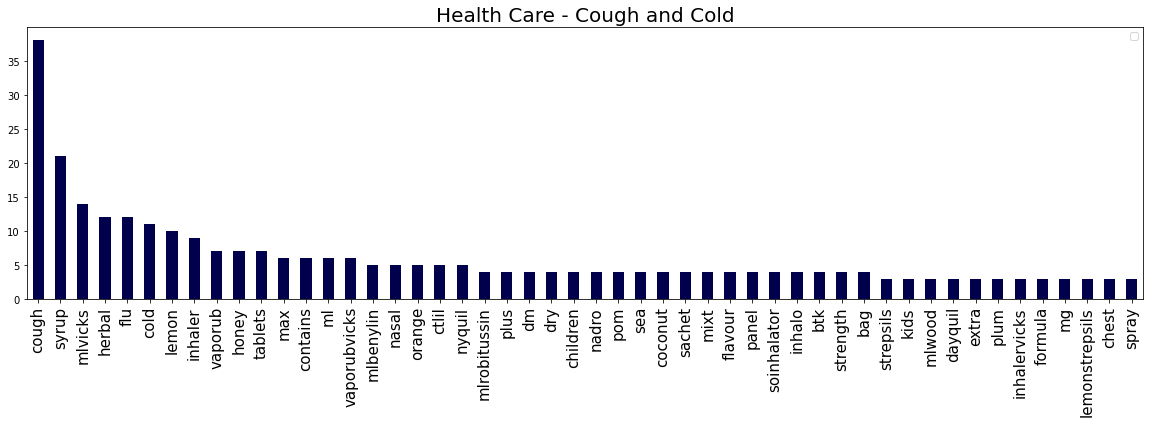

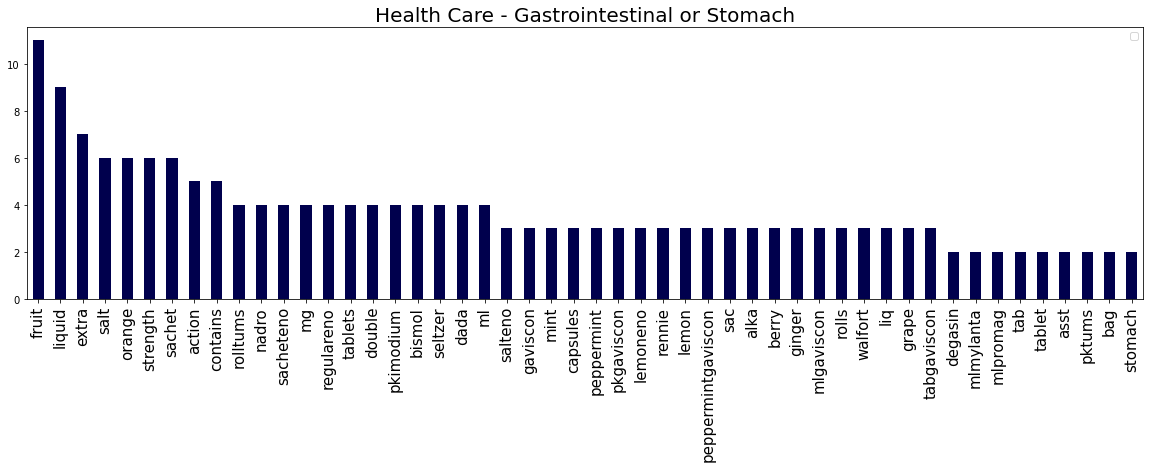

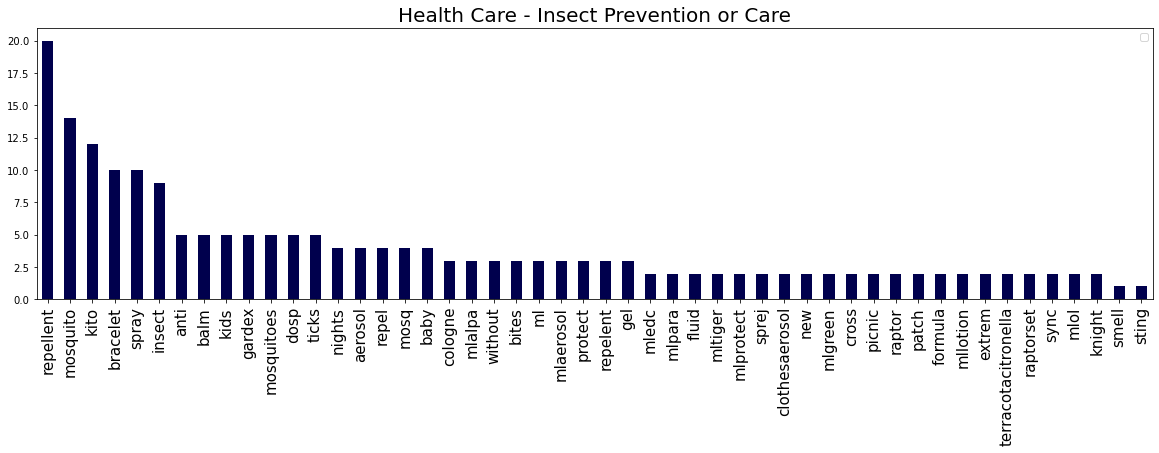

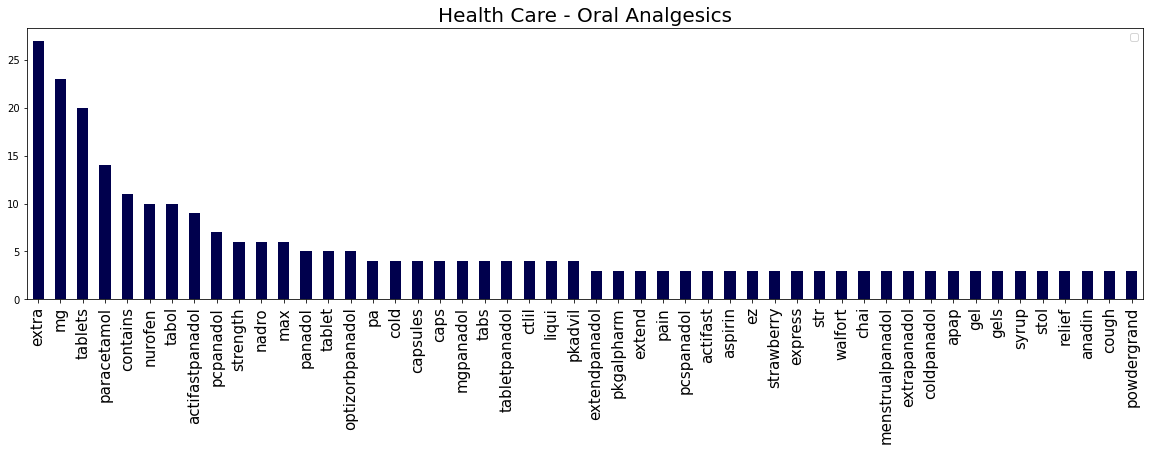

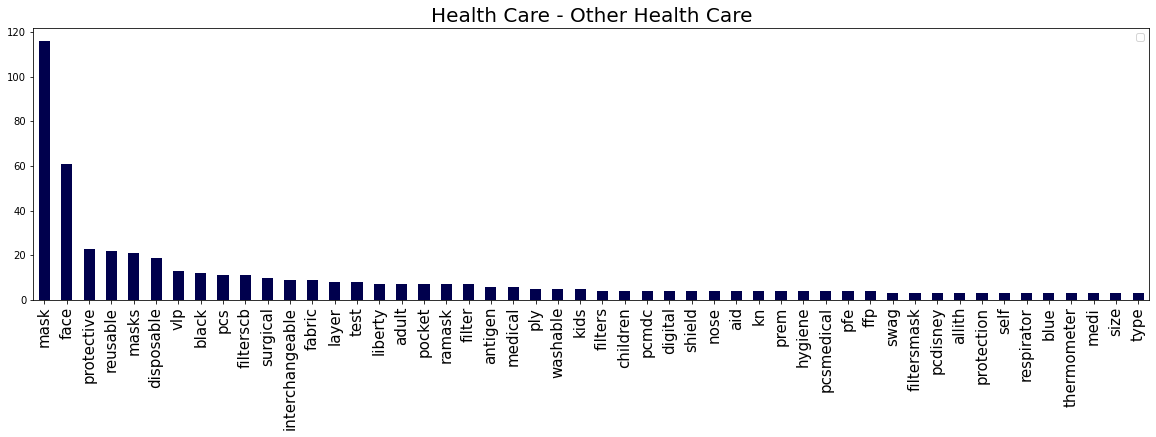

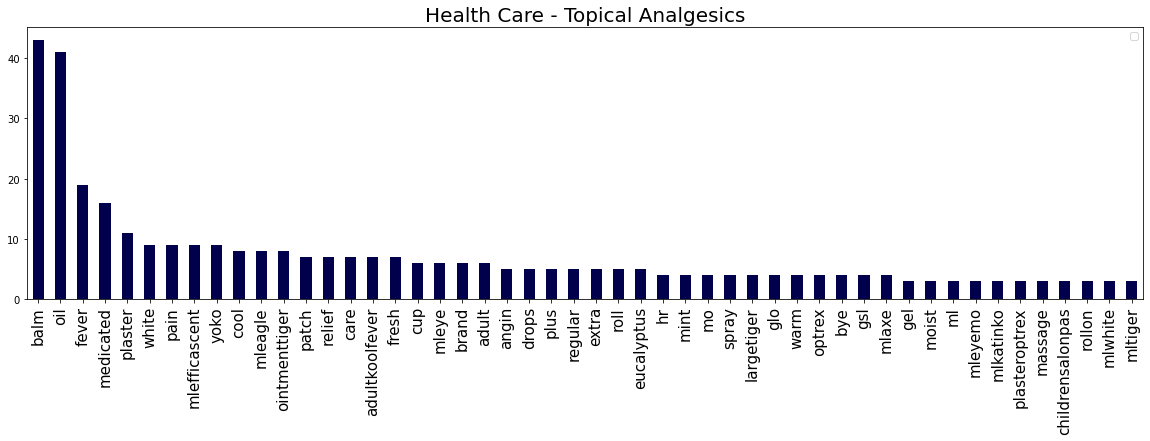

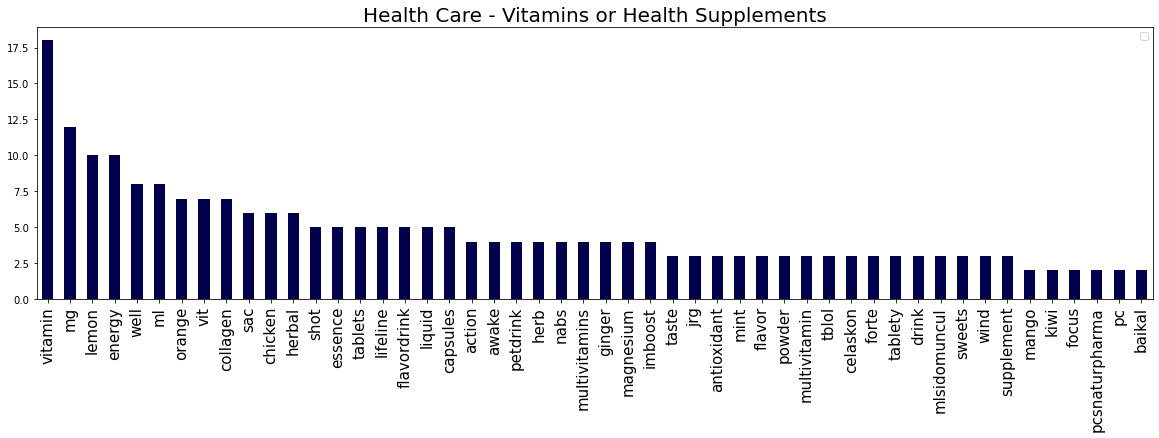

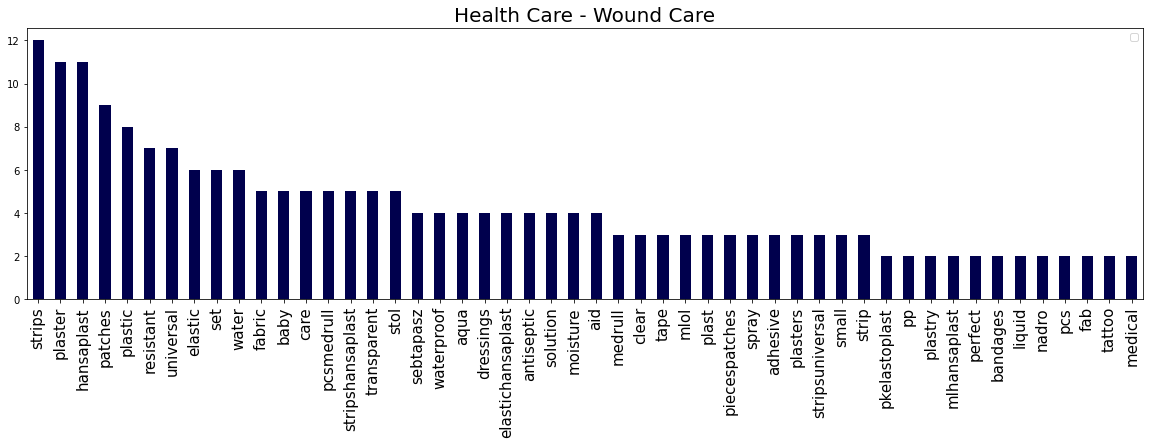

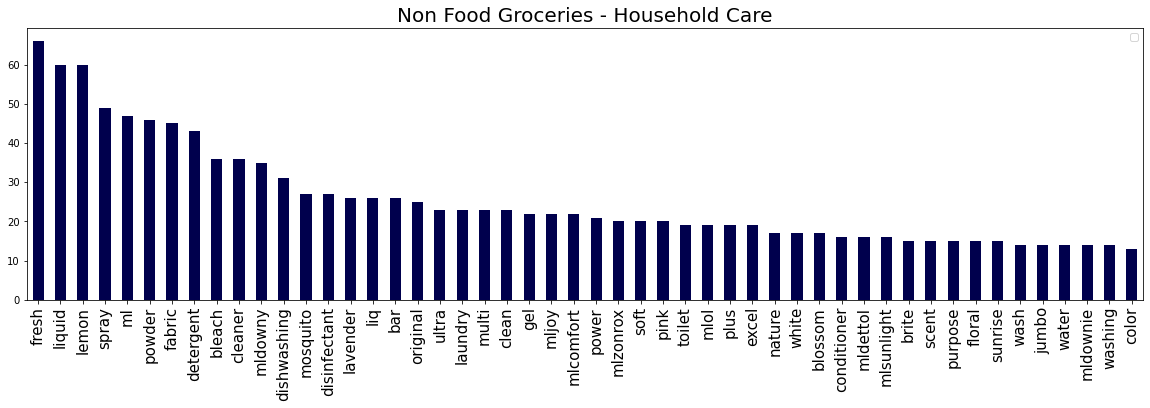

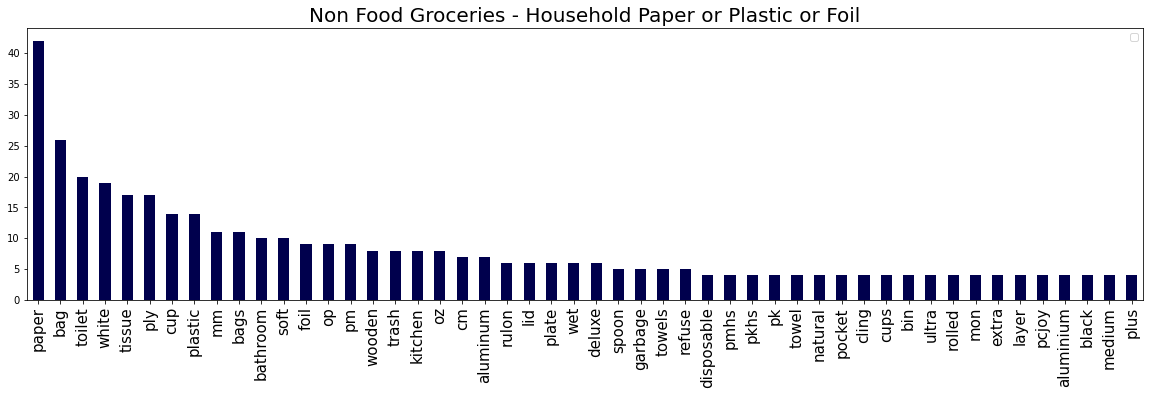

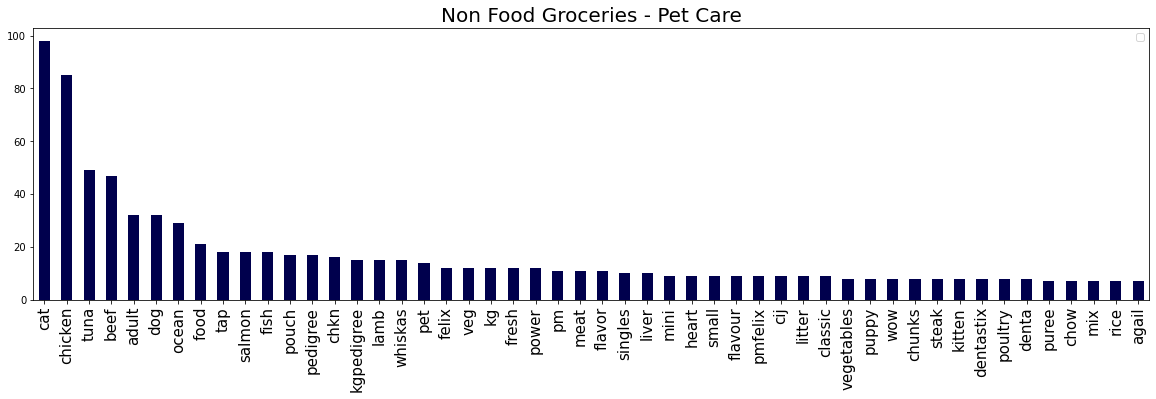

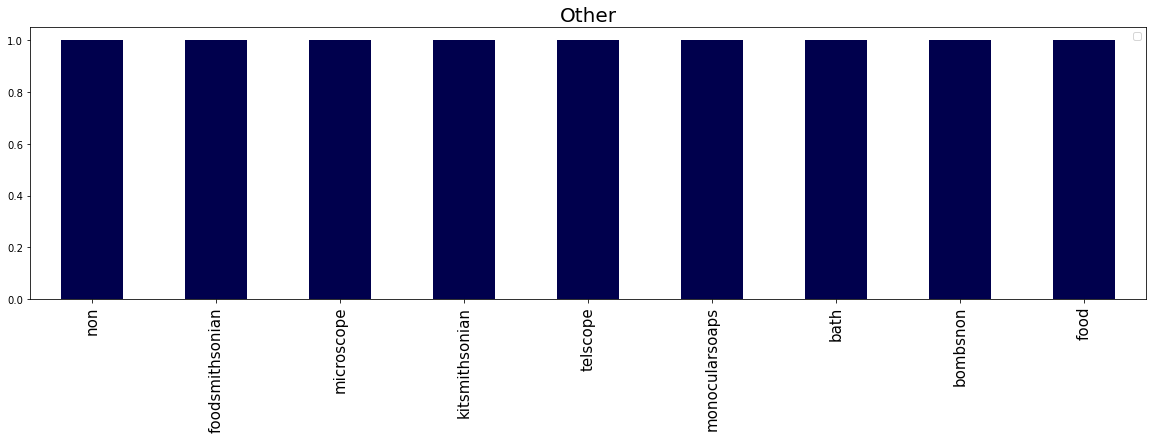

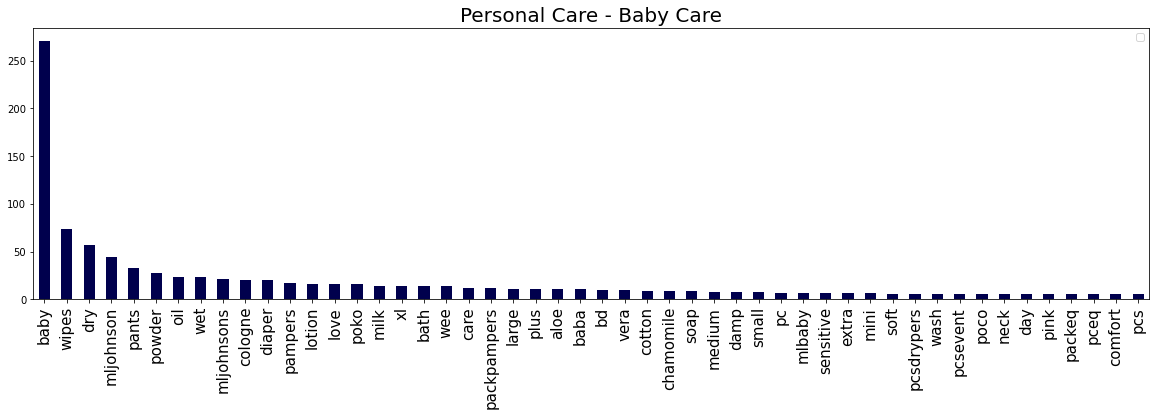

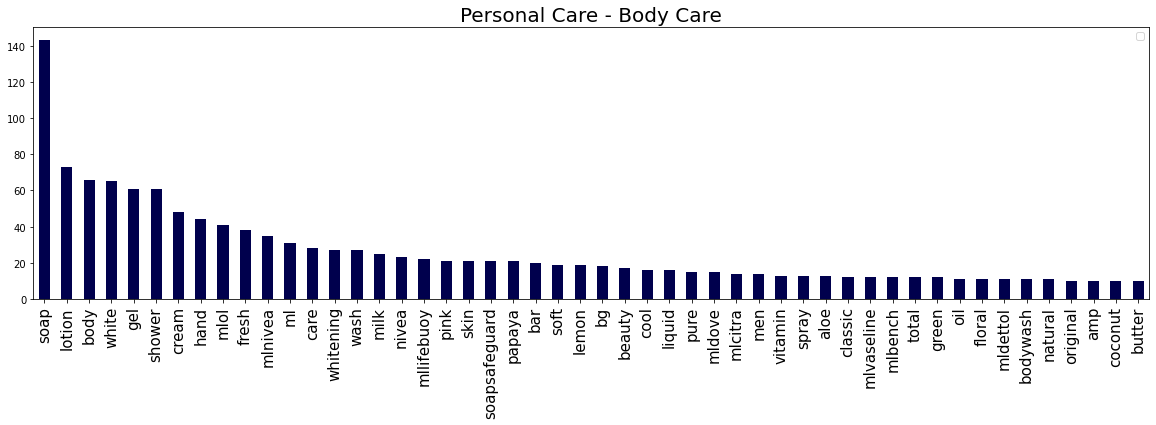

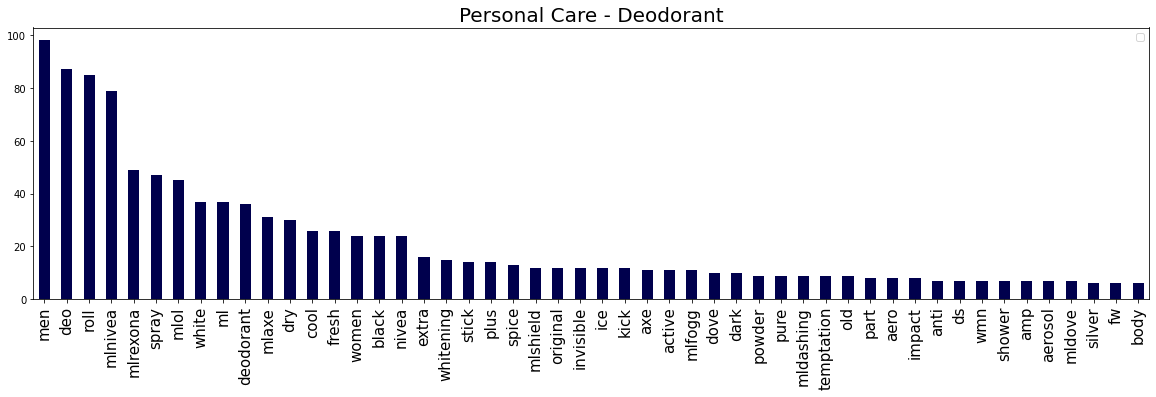

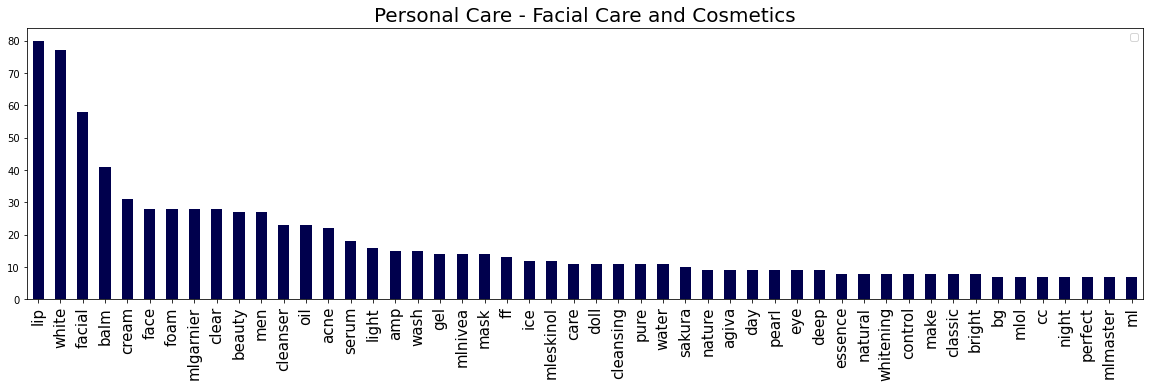

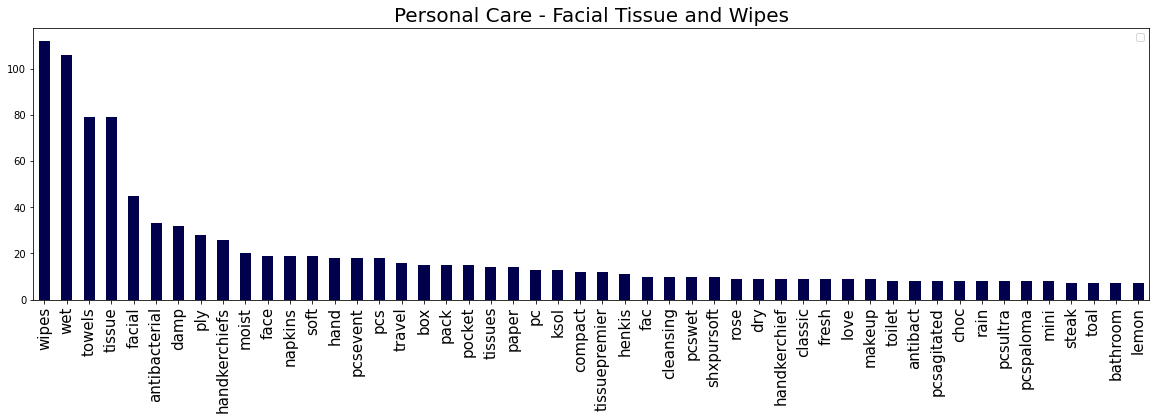

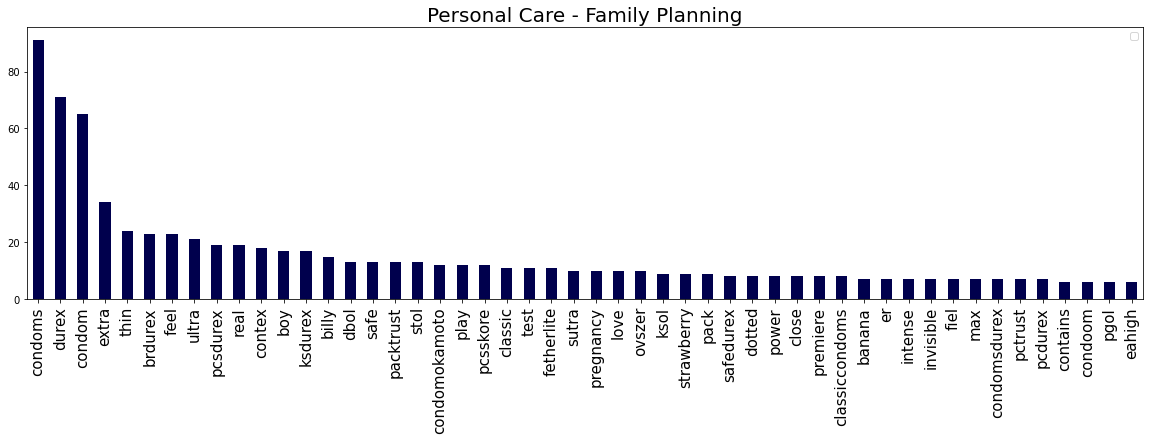

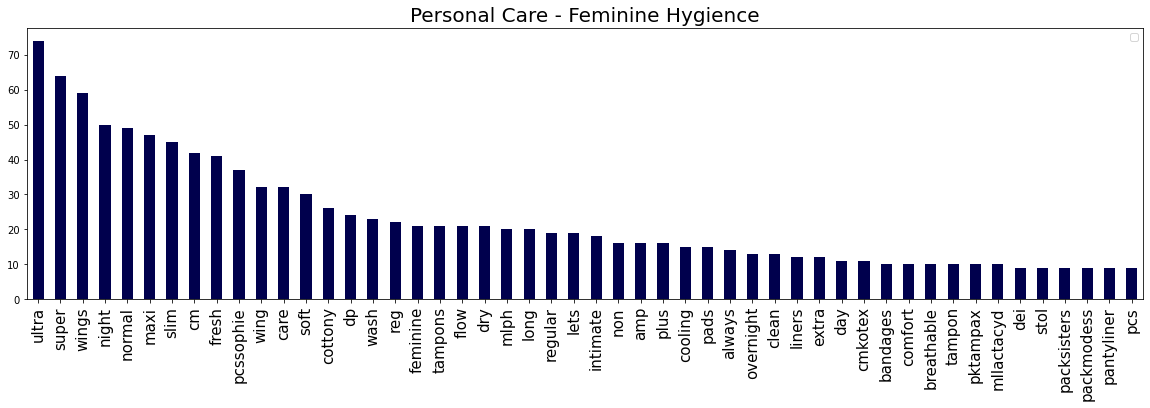

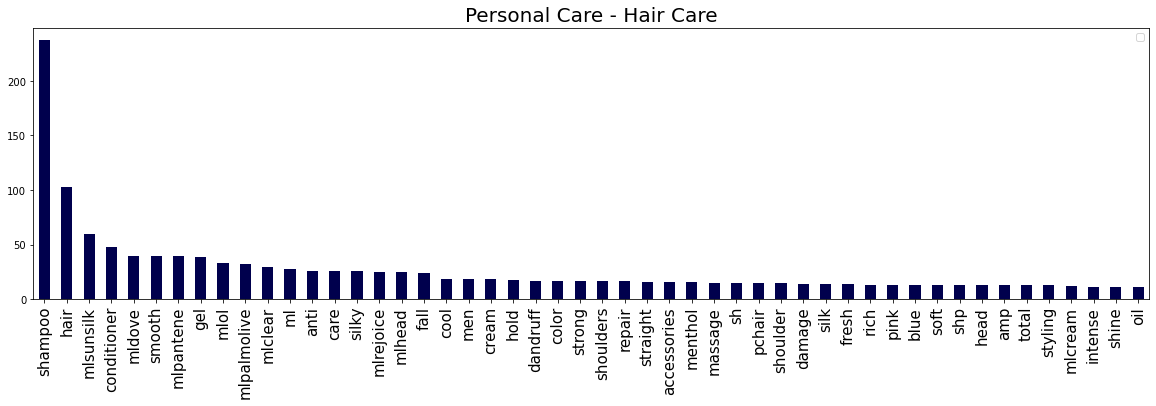

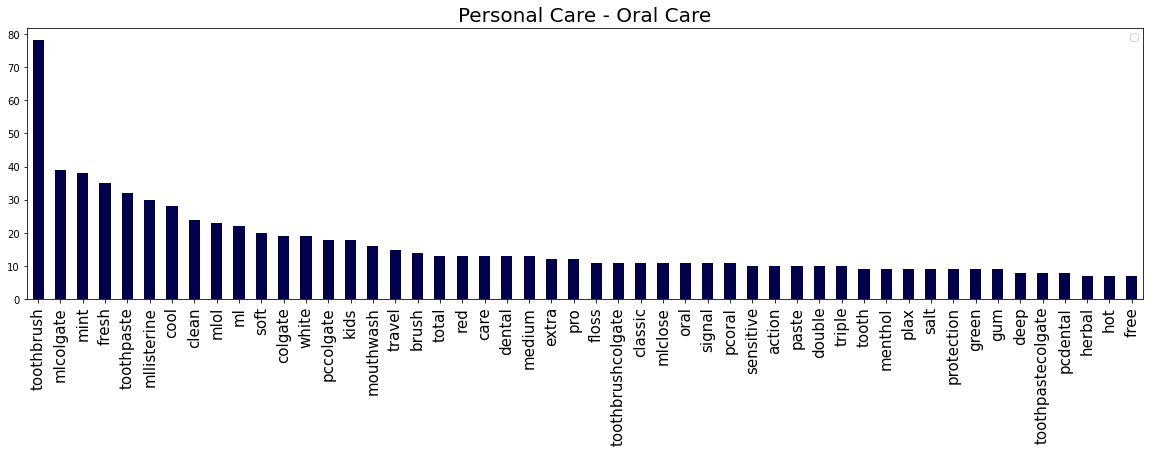

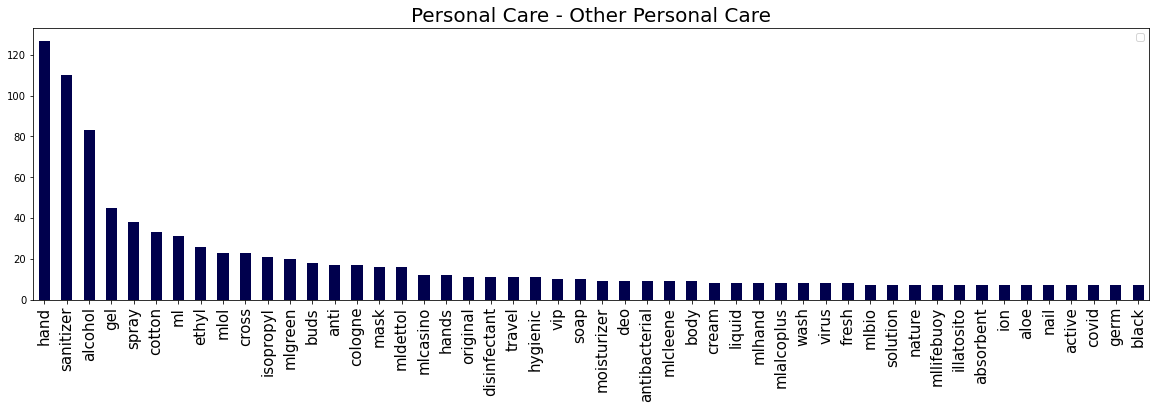

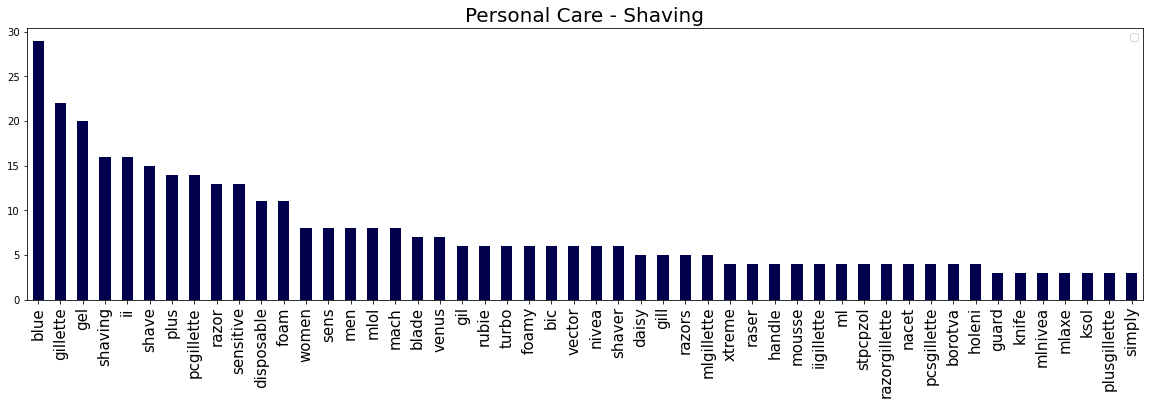

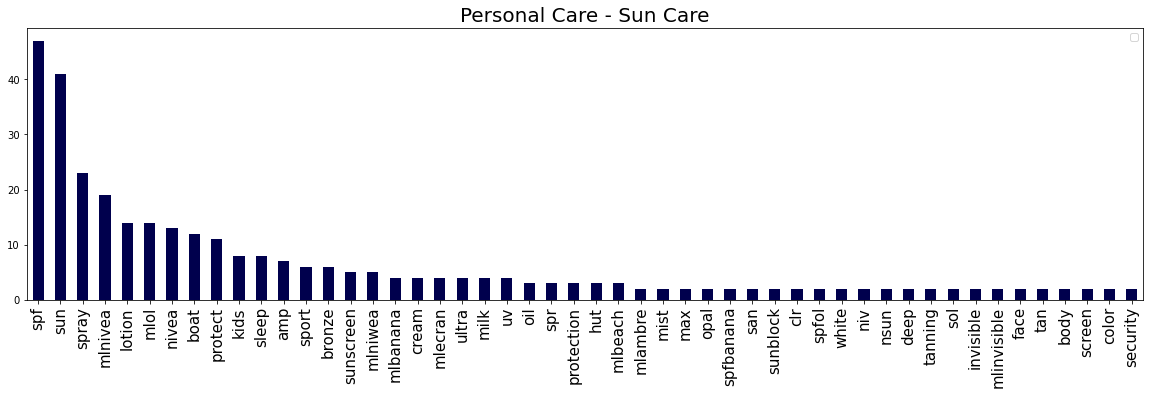

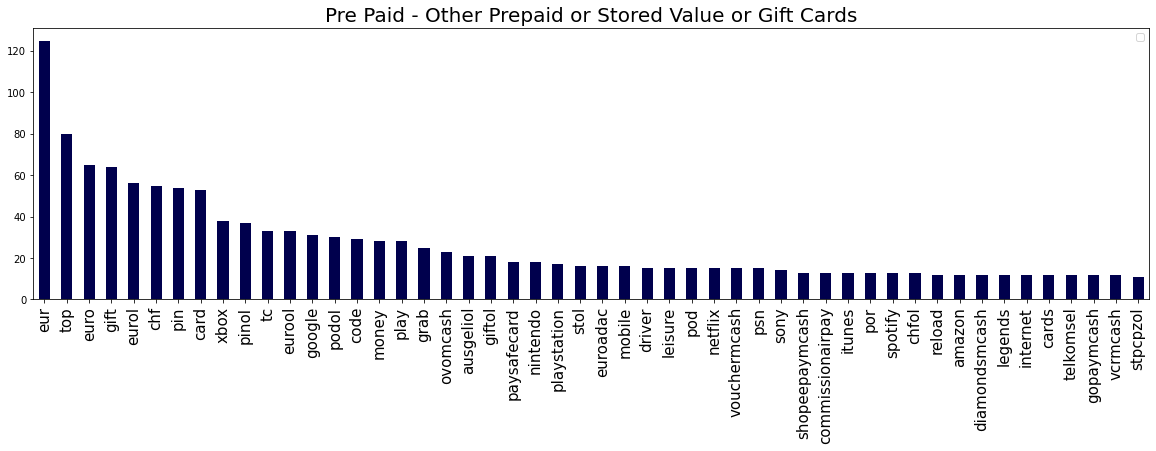

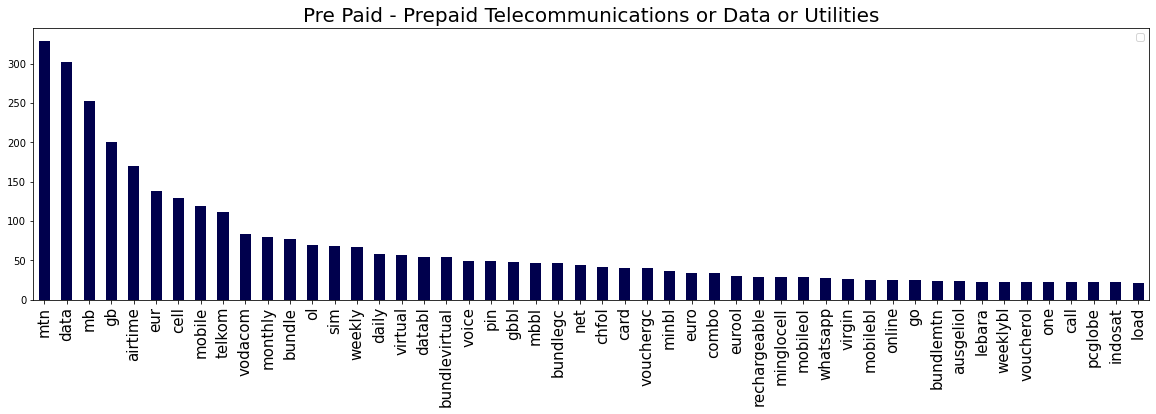

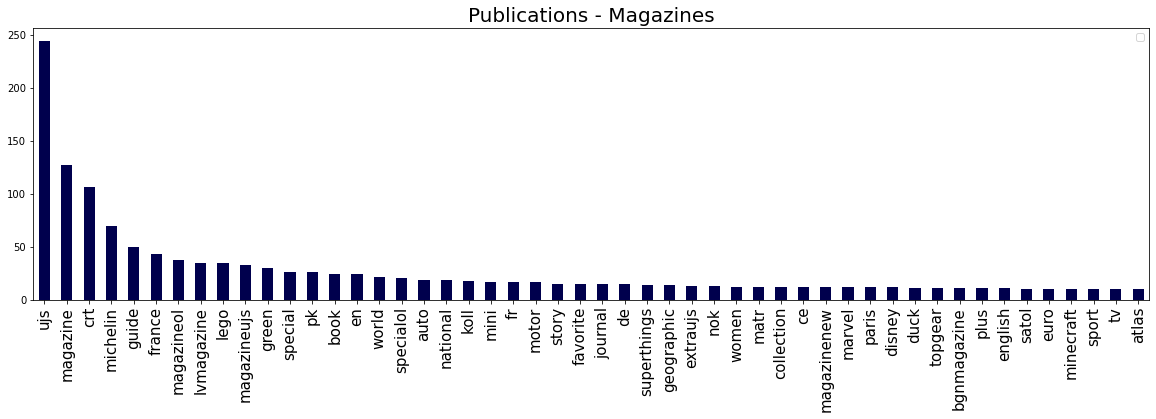

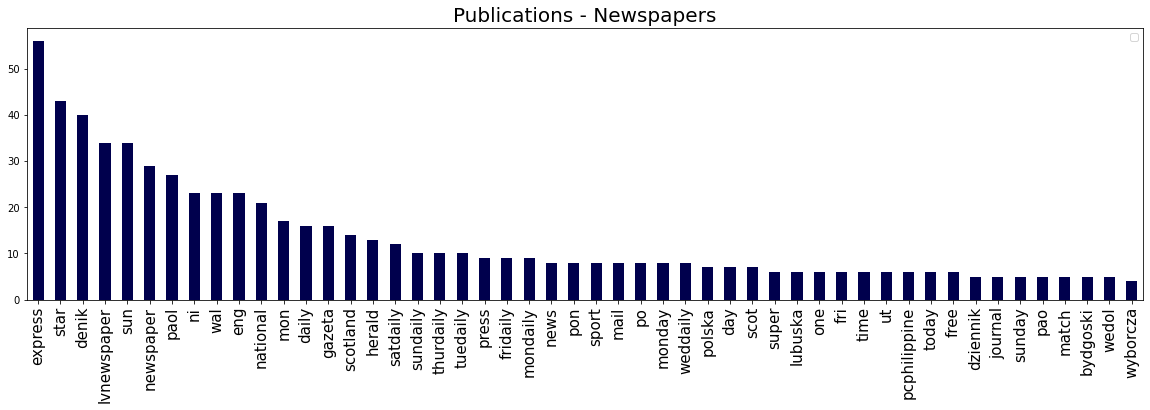

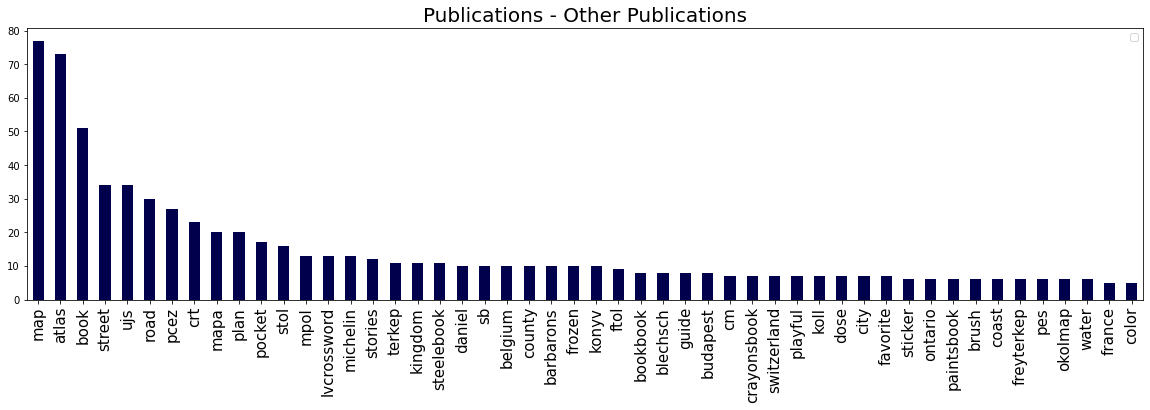

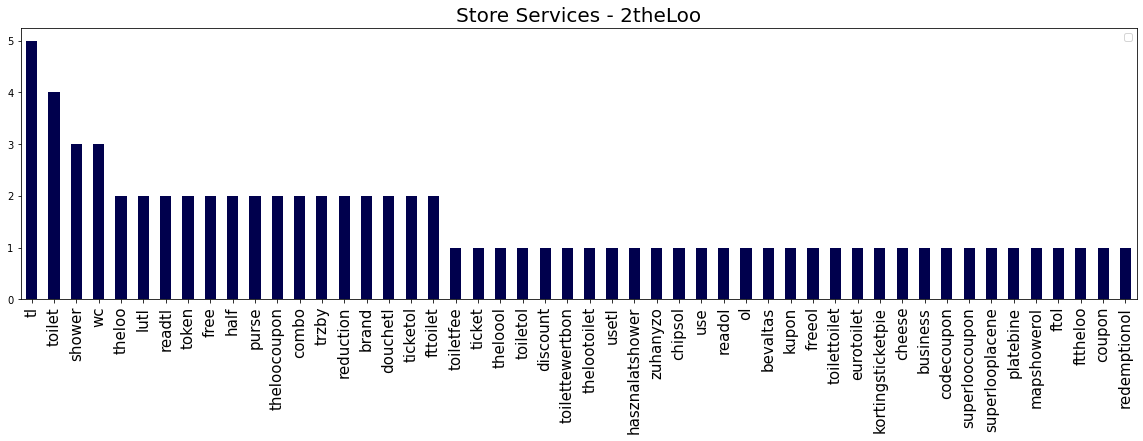

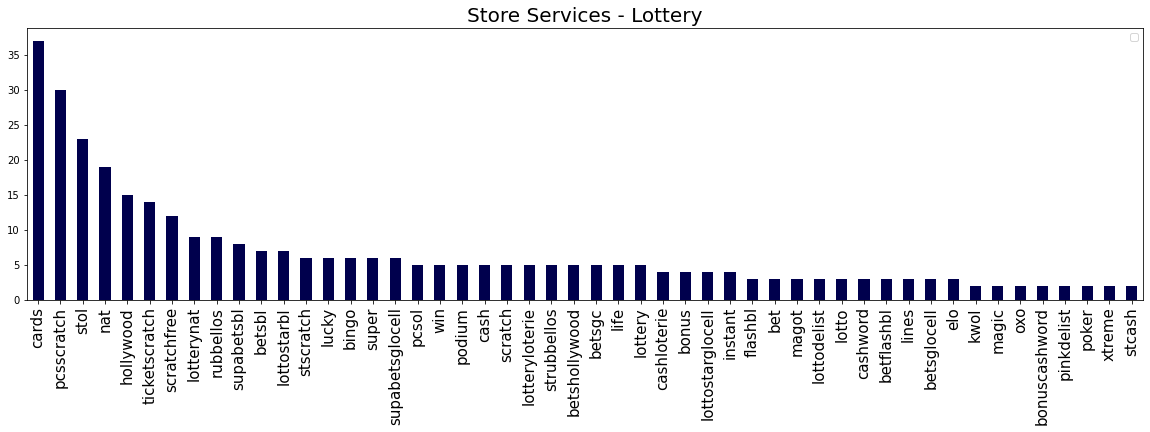

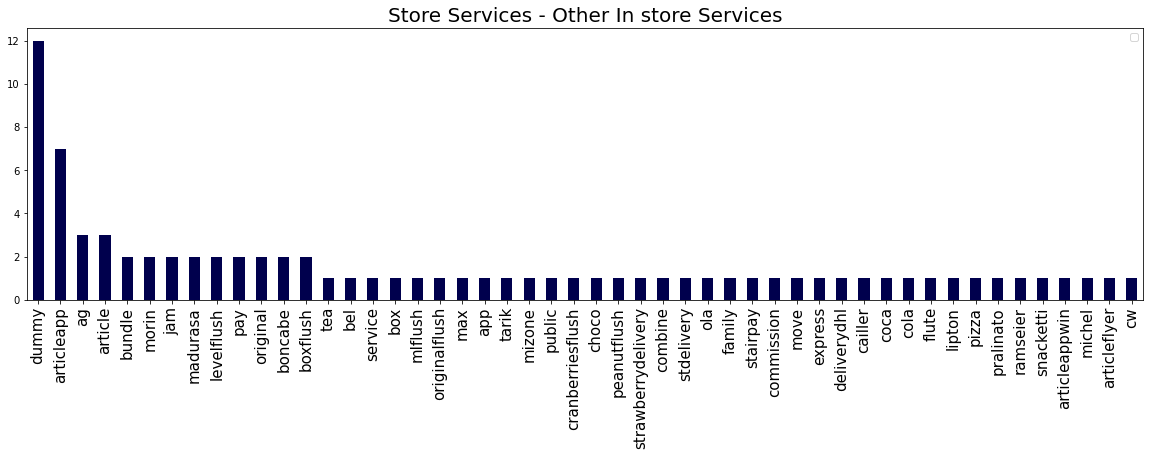

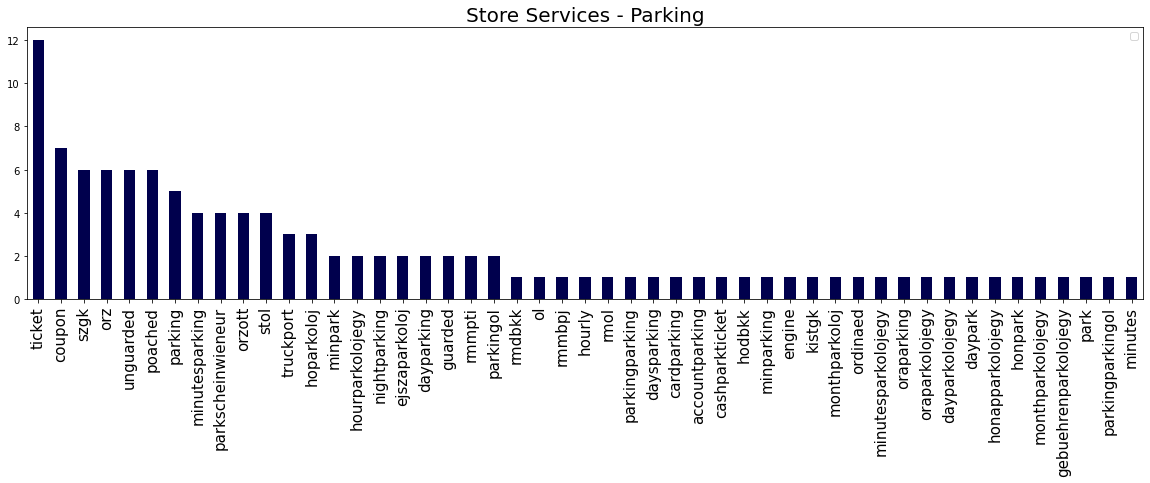

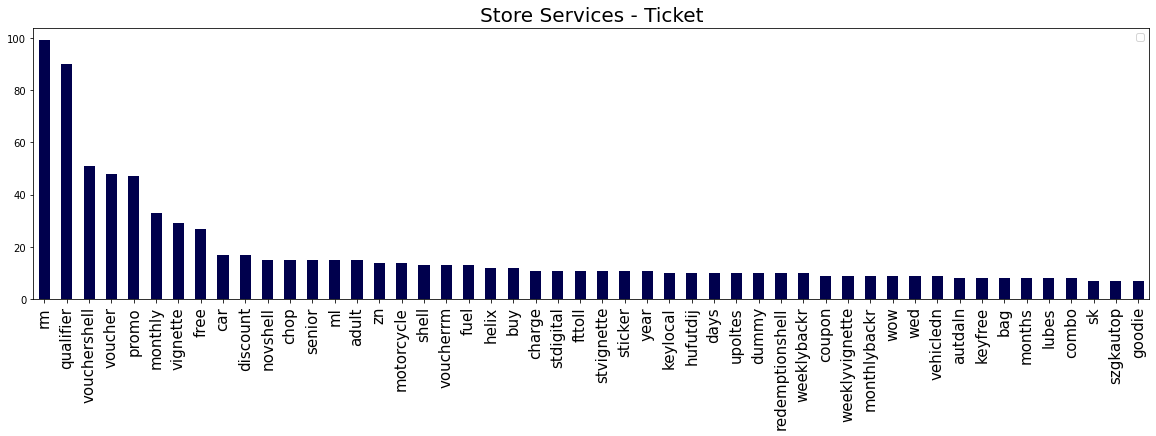

In [27]:
plot_most_common_features(X_cleaner_2,df['Final_Category'])

In [28]:
warnings.filterwarnings('ignore') # Do not print warning messages

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [30]:
def text_p(X):
    return X.apply(lambda x: process_text(x))  

In [31]:
def stemming_func(X):
    return X.apply(lambda x: stemming(x))

In [32]:
count_vect = CountVectorizer(analyzer = "word")
tfidf = TfidfTransformer(norm="l2")

In [33]:
text_process = FunctionTransformer(text_p)
stemming_text = FunctionTransformer(stemming_func)

In [34]:
naive_multi = MultinomialNB()
svc = SVC()
rf = RandomForestClassifier(n_jobs=-1)
lr = LogisticRegression(multi_class='ovr')

In [35]:
pipeline = Pipeline([
    ('process', text_process),
    ('stemmer', stemming_text),
    ('count_vector', count_vect),
    ('tfidf', tfidf),
    ('model', naive_multi)
])
pipeline

Pipeline(steps=[('process',
                 FunctionTransformer(func=<function text_p at 0x000002956BB86310>)),
                ('stemmer',
                 FunctionTransformer(func=<function stemming_func at 0x000002956BB86160>)),
                ('count_vector', CountVectorizer()),
                ('tfidf', TfidfTransformer()), ('model', MultinomialNB())])

In [36]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('process',
                 FunctionTransformer(func=<function text_p at 0x000002956BB86310>)),
                ('stemmer',
                 FunctionTransformer(func=<function stemming_func at 0x000002956BB86160>)),
                ('count_vector', CountVectorizer()),
                ('tfidf', TfidfTransformer()), ('model', MultinomialNB())])

In [37]:
from sklearn.metrics import accuracy_score

In [38]:
matthews_corrcoef(y_train, pipeline.predict(X_train))

0.7503252638799391

In [39]:
recall_score(y_train, pipeline.predict(X_train), average='macro')

0.49064558092099936

In [40]:
#GridSearch

In [41]:
Cs = 10**np.linspace(-1,2,3)
gammas = 10**np.linspace(-2,1,5)

In [42]:
param_grid = [
    {'model': [svc], 'model__kernel': ['linear'], 'model__C': Cs, 'tfidf': [None, tfidf], 'stemmer': [None, stemming_text]},
    {'model': [svc], 'model__kernel': ['rbf'], 'model__gamma': gammas, 'tfidf': [None, tfidf], 'stemmer': [None, stemming_text]},
    {'model': [naive_multi], 'tfidf': [None, tfidf], 'stemmer': [None, stemming_text]},
    {'model': [lr], 'tfidf': [None, tfidf], 'stemmer': [None, stemming_text]},
    {'model': [rf], 'tfidf': [None, tfidf], 'stemmer': [None, stemming_text]}
]

In [43]:
cv = ShuffleSplit(n_splits=5, test_size=0.2)

In [44]:
sklearn.metrics.get_scorer

<function sklearn.metrics._scorer.get_scorer(scoring)>

In [45]:
#%%time
#gs = GridSearchCV(
    #pipeline,
    #param_grid,
    #cv = cv,
    #n_jobs=-1
    #scoring=make_scorer(matthews_corrcoef)
#)
#gs.fit(X_train, y_train)

In [46]:
#gs = gs.fit(X_train, y_train)

In [47]:
from sklearn.model_selection import RandomizedSearchCV

In [48]:
randcv = RandomizedSearchCV(pipeline,param_grid,cv = cv,n_iter=10,scoring=make_scorer(matthews_corrcoef),verbose=10)
randcv.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START model=SVC(), model__gamma=1.7782794100389228, model__kernel=rbf, stemmer=FunctionTransformer(func=<function stemming_func at 0x000002956BB86160>), tfidf=TfidfTransformer()
[CV 1/5; 1/10] END model=SVC(), model__gamma=1.7782794100389228, model__kernel=rbf, stemmer=FunctionTransformer(func=<function stemming_func at 0x000002956BB86160>), tfidf=TfidfTransformer();, score=0.774 total time= 1.7min
[CV 2/5; 1/10] START model=SVC(), model__gamma=1.7782794100389228, model__kernel=rbf, stemmer=FunctionTransformer(func=<function stemming_func at 0x000002956BB86160>), tfidf=TfidfTransformer()
[CV 2/5; 1/10] END model=SVC(), model__gamma=1.7782794100389228, model__kernel=rbf, stemmer=FunctionTransformer(func=<function stemming_func at 0x000002956BB86160>), tfidf=TfidfTransformer();, score=0.763 total time= 1.7min
[CV 3/5; 1/10] START model=SVC(), model__gamma=1.7782794100389228, model__kernel=rbf, stemmer=FunctionTra

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.2, train_size=None),
                   estimator=Pipeline(steps=[('process',
                                              FunctionTransformer(func=<function text_p at 0x000002956BB86310>)),
                                             ('stemmer',
                                              FunctionTransformer(func=<function stemming_func at 0x000002956BB86160>)),
                                             ('count_vector',
                                              CountVectorizer()),
                                             ('tfidf', TfidfTransformer()),
                                             ('model'...
                                        {'model': [LogisticRegression(multi_class='ovr')],
                                         'stemmer': [None,
                                                     FunctionTransformer(func=<function stemming_func at 0x000002956BB86160>)],
                                         'tfidf': [None, TfidfTransformer()]},
                                        {'model': [RandomForestClassifier(n_jobs=-1)],
                                         'stemmer': [None,
                                                     FunctionTransformer(func=<function stemming_func at 0x000002956BB86160>)],
                                         'tfidf': [None, TfidfTransformer()]}],
                   scoring=make_scorer(matthews_corrcoef), verbose=10)

In [49]:
#gs_results = pd.DataFrame(gs.cv_results_).sort_values(['rank_test_score'])
#gs_results.head()

In [50]:
randcv_results = pd.DataFrame(randcv.cv_results_).sort_values(['rank_test_score'])
randcv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
6      34.953420      0.249678        10.136735        0.593134   
5      20.640443      0.264622         2.495193        0.055092   
3      21.922618      1.801337         2.539261        0.080637   
2      47.386521      1.675051        10.827209        0.056198   
0      93.638841     12.745102        12.442148        0.335057   

          param_tfidf                                      param_stemmer  \
6  TfidfTransformer()                                               None   
5                None                                               None   
3                None  FunctionTransformer(func=<function stemming_fu...   
2  TfidfTransformer()                                               None   
0  TfidfTransformer()  FunctionTransformer(func=<function stemming_fu...   

  param_model__kernel param_model__gamma                        param_model  \
6              linear                NaN      SVC(C=100.0, kernel='linear')   
5                 NaN                NaN  RandomForestClassifier(n_jobs=-1)   
3                 NaN                NaN  RandomForestClassifier(n_jobs=-1)   
2                 rbf           0.316228      SVC(C=100.0, kernel='linear')   
0                 rbf           1.778279      SVC(C=100.0, kernel='linear')   

  param_model__C                                             params  \
6          100.0  {'tfidf': TfidfTransformer(), 'stemmer': None,...   
5            NaN  {'tfidf': None, 'stemmer': None, 'model': Rand...   
3            NaN  {'tfidf': None, 'stemmer': FunctionTransformer...   
2            NaN  {'tfidf': TfidfTransformer(), 'stemmer': None,...   
0            NaN  {'tfidf': TfidfTransformer(), 'stemmer': Funct...   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
6           0.823661           0.825075           0.819156           0.827960   
5           0.803999           0.792151           0.782906           0.797169   
3           0.803179           0.792967           0.784119           0.796207   
2           0.780494           0.768628           0.770943           0.776056   
0           0.773554           0.763327           0.770094           0.768671   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
6           0.811604         0.821491        0.005703                1  
5           0.790175         0.793280        0.007051                2  
3           0.789767         0.793248        0.006371                3  
2           0.773844         0.773993        0.004114                4  
0           0.765924         0.768314        0.003502                5

In [51]:
randcv.best_score_

0.8214910537284545

In [52]:
#gs.best_score_

In [53]:
#best_params = gs.best_estimator_.get_params()

In [54]:
best_params = randcv.best_estimator_.get_params()

In [55]:
pipeline.set_params(**best_params)

Pipeline(steps=[('process',
                 FunctionTransformer(func=<function text_p at 0x000002956BB86310>)),
                ('stemmer', None), ('count_vector', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('model', SVC(C=100.0, kernel='linear'))])

In [56]:
matthews_corrcoef(y_test, pipeline.predict(X_test))

0.8178713796968864

(array([3., 2., 1., 3., 6., 8., 4., 7., 7., 4.]),
 array([0.51428571, 0.56285714, 0.61142857, 0.66      , 0.70857143,
        0.75714286, 0.80571429, 0.85428571, 0.90285714, 0.95142857,
        1.        ]),
 <BarContainer object of 10 artists>)

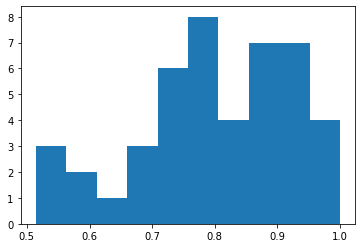

In [57]:
plt.hist(recall_score(y_test, pipeline.predict(X_test), average=None))

(array([0.06666667, 0.11111111, 0.13333333, 0.2       , 0.33333333,
        0.51111111, 0.6       , 0.75555556, 0.91111111, 1.        ]),
 array([0.51428571, 0.56285714, 0.61142857, 0.66      , 0.70857143,
        0.75714286, 0.80571429, 0.85428571, 0.90285714, 0.95142857,
        1.        ]),
 <BarContainer object of 10 artists>)

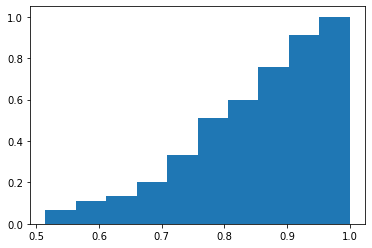

In [58]:
plt.hist(recall_score(y_test, pipeline.predict(X_test), average=None), cumulative=True, density=True)

In [59]:
recall_score(y_test, pipeline.predict(X_test), average='macro')

0.8004810822095166

In [60]:
test_set = pd.read_excel('test_set2_10.xlsx')

In [61]:
final_prediction = pd.DataFrame(X_test.copy())

In [62]:
test_set['Prediction'] = pipeline.predict(test_set['Production Description Test'])

In [63]:
test_set.head(20)

Production Description Test  Prediction
0                Emerald Langstielrosen Rot/          41
1                              FFP2 Mask 1st          15
2             OL: Fertiglesebrille Dpt +2.00           9
3                  Heart Pillow,26cm(12) 1st           9
4                  Heart Pillow,26cm(12) 1st           9
5               Einwegmasken 31g 50er Pg 1St          41
6                   Gf Liver Cheese Foil 1st          20
7                        OL: Filialpost 1 St           4
8                 Paper snack bags White 1pc          20
9                           OL: BMW X6 M 1St           9
10                     OL: Eisschaber 2K 1St           4
11            OL: Fertiglesebrille Dpt +1.50           9
12          Pillow Heart I love you 2f, 26cm           9
13                  Pillow Llama 3f, 40x40cm           9
14                  Lena Freundsch bends20cm           9
15                     OL: Comic Einhorn 1St           9
16                   Sleeping hats Bear 22cm           9
17                          Want to want 1St          37
18  MyCoffeeCup Lid Bulk Resistant Large 1St           9
19            Neck pillow Dunlop 34x30 sort.           4

In [64]:
test_set.replace({'Prediction': code_dictionary}, inplace=True)

In [65]:
test_set.head()

Production Description Test  \
0     Emerald Langstielrosen Rot/   
1                   FFP2 Mask 1st   
2  OL: Fertiglesebrille Dpt +2.00   
3       Heart Pillow,26cm(12) 1st   
4       Heart Pillow,26cm(12) 1st   

                                          Prediction  
0                           Store Services - Lottery  
1                    Health Care - Other Health Care  
2  General Merchandise - Toys or Gifting or Leisu...  
3  General Merchandise - Toys or Gifting or Leisu...  
4  General Merchandise - Toys or Gifting or Leisu...

In [66]:
test_set = test_set.join(test_set['Prediction'].str.split('-', expand=True).rename(columns={0:'Predicted IPH Category', 1: 'Predicted IPH Sub Category'}))

In [67]:
test_set.head(20)

Production Description Test  \
0                Emerald Langstielrosen Rot/   
1                              FFP2 Mask 1st   
2             OL: Fertiglesebrille Dpt +2.00   
3                  Heart Pillow,26cm(12) 1st   
4                  Heart Pillow,26cm(12) 1st   
5               Einwegmasken 31g 50er Pg 1St   
6                   Gf Liver Cheese Foil 1st   
7                        OL: Filialpost 1 St   
8                 Paper snack bags White 1pc   
9                           OL: BMW X6 M 1St   
10                     OL: Eisschaber 2K 1St   
11            OL: Fertiglesebrille Dpt +1.50   
12          Pillow Heart I love you 2f, 26cm   
13                  Pillow Llama 3f, 40x40cm   
14                  Lena Freundsch bends20cm   
15                     OL: Comic Einhorn 1St   
16                   Sleeping hats Bear 22cm   
17                          Want to want 1St   
18  MyCoffeeCup Lid Bulk Resistant Large 1St   
19            Neck pillow Dunlop 34x30 sort.   

                                           Prediction Predicted IPH Category  \
0                            Store Services - Lottery        Store Services    
1                     Health Care - Other Health Care           Health Care    
2   General Merchandise - Toys or Gifting or Leisu...   General Merchandise    
3   General Merchandise - Toys or Gifting or Leisu...   General Merchandise    
4   General Merchandise - Toys or Gifting or Leisu...   General Merchandise    
5                            Store Services - Lottery        Store Services    
6   Non Food Groceries - Household Paper or Plasti...    Non Food Groceries    
7   General Merchandise - Communication and IT Acc...   General Merchandise    
8   Non Food Groceries - Household Paper or Plasti...    Non Food Groceries    
9   General Merchandise - Toys or Gifting or Leisu...   General Merchandise    
10  General Merchandise - Communication and IT Acc...   General Merchandise    
11  General Merchandise - Toys or Gifting or Leisu...   General Merchandise    
12  General Merchandise - Toys or Gifting or Leisu...   General Merchandise    
13  General Merchandise - Toys or Gifting or Leisu...   General Merchandise    
14  General Merchandise - Toys or Gifting or Leisu...   General Merchandise    
15  General Merchandise - Toys or Gifting or Leisu...   General Merchandise    
16  General Merchandise - Toys or Gifting or Leisu...   General Merchandise    
17                           Publications - Magazines          Publications    
18  General Merchandise - Toys or Gifting or Leisu...   General Merchandise    
19  General Merchandise - Communication and IT Acc...   General Merchandise    

                           Predicted IPH Sub Category  
0                                             Lottery  
1                                   Other Health Care  
2    Toys or Gifting or Leisure or Recreational Eq...  
3    Toys or Gifting or Leisure or Recreational Eq...  
4    Toys or Gifting or Leisure or Recreational Eq...  
5                                             Lottery  
6                  Household Paper or Plastic or Foil  
7                    Communication and IT Accessories  
8                  Household Paper or Plastic or Foil  
9    Toys or Gifting or Leisure or Recreational Eq...  
10                   Communication and IT Accessories  
11   Toys or Gifting or Leisure or Recreational Eq...  
12   Toys or Gifting or Leisure or Recreational Eq...  
13   Toys or Gifting or Leisure or Recreational Eq...  
14   Toys or Gifting or Leisure or Recreational Eq...  
15   Toys or Gifting or Leisure or Recreational Eq...  
16   Toys or Gifting or Leisure or Recreational Eq...  
17                                          Magazines  
18   Toys or Gifting or Leisure or Recreational Eq...  
19                   Communication and IT Accessories

In [68]:
test_set.to_csv('iphpredictions2_10.csv')